In [1]:
import pandas as pd
import numpy as np
from numba import jit
from numba.typed import List
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import statsmodels.api as sm
from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.stats import pointbiserialr
import pymc3 as pm
import shutil
import time
import os
import warnings  # Added to handle UserWarnings

# Suppress UserWarnings related to plt.tight_layout()
warnings.filterwarnings("ignore", category=UserWarning)

# Switch to the log-likelihood based formula for BIC in statsmodels
import statsmodels.genmod.generalized_linear_model as glm
glm.SET_USE_BIC_LLF(True)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


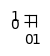

In [2]:
# Dummy plot
fig, ax = plt.subplots(figsize=(0.1, 0.1))
ax.axhline(y=1, color='grey', linestyle='-')
plt.rcParams.update({'font.size': 30})

In [3]:
extinction_threshold = 0.1  # threshold below which a species is considered extinct

In [4]:
@jit(nopython=True)
def competitive_ability(r1, r2, a11, a22, a12, a21):
    CA1 = (r1 - 1) / np.sqrt(a12 * a11)
    CA2 = (r2 - 1) / np.sqrt(a21 * a22)
    return CA1, CA2

@jit(nopython=True)
def competitive_efficiency(r1, r2, a11, a22, a12, a21):
    tolerance = 1e-9
    CE1 = ((r1 - 1) / a12) - ((r2 - 1) / a22)
    CE2 = ((r2 - 1) / a21) - ((r1 - 1) / a11)
    if abs(CE1) <= tolerance and abs(CE2) <= tolerance:
        return CE1, CE2, 'local_coexistence'
    elif CE1 * CE2 < 0 or (abs(CE1) <= tolerance and abs(CE2) >= tolerance) or (abs(CE2) <= tolerance and abs(CE1) >= tolerance):
        return CE1, CE2, 'global_competitive_exclusion'
    elif CE1 < 0 and CE2 < 0:
        return CE1, CE2, 'local_competitive_exclusion'
    elif CE1 > 0 and CE2 > 0:
        return CE1, CE2, 'global_coexistence'

# getNFD.r

In [5]:
@jit(nopython=True)
def strength_of_stabilization(r1, r2, a11, a22, a12, a21):
#     The original code from Yenni et al. replaced r1 with r2
    SoS1 = r1 / (1 + (a12 / a22) * (r2 - 1))
    SoS2 = r2 / (1 + (a21 / a11) * (r1 - 1))
    return SoS1, SoS2

@jit(nopython=True)
def get_per_capita_growth_rate(r1, r2, a11, a22, a12, a21, N1, N2):
    new_N = np.zeros(2)
    new_N[0] = r1 * N1 / (1 + a11 * N1 + a12 * N2)
    new_N[1] = r2 * N2 / (1 + a21 * N1 + a22 * N2)
    out = np.zeros(2)
    out[0] = np.log(new_N[0]) - np.log(N1)  # per capita growth rate of species 1
    out[1] = np.log(new_N[1]) - np.log(N2)  # per capita growth rate of species 2
    return out

@jit(nopython=True)
def get_equilibrium_density(fixed_species, r1, r2, a11, a22, a12, a21, N_star):
    if fixed_species == 1:  # density of species 1 is known
        N2_star = (r2 - 1 - a21 * N_star) / a22
        return N2_star
    elif fixed_species == 2:  # density of species 2 is known
        N1_star = (r1 - 1 - a12 * N_star) / a11
        return N1_star
    else:
        raise ValueError("Invalid 'fixed_species' value. Must be either 1 or 2.")

@jit(nopython=True)
def calculate_frequency(N_focal, N_other):
    freq = N_focal / (N_focal + N_other)
    return freq

@jit(nopython=True)
def get_negative_frequency_dependence(r1, r2, a11, a22, a12, a21, lowN, highN):
    pgr1, freq1, pgr2, freq2 = np.zeros(2), np.zeros(2), np.zeros(2), np.zeros(2)
    # Get low density growth rate for spp 1
    tmpN = np.zeros(2)
    tmpN[0] = lowN
    tmpN[1] = get_equilibrium_density(1, r1, r2, a11, a22, a12, a21, N_star=tmpN[0])
    tmpOut = get_per_capita_growth_rate(r1, r2, a11, a22, a12, a21, tmpN[0], tmpN[1])
    pgr1[0] = tmpOut[0]
    freq1[0] = calculate_frequency(tmpN[0], tmpN[1])
    # Get low density growth rate for spp 2
    tmpN = np.zeros(2)
    tmpN[1] = lowN
    tmpN[0] = get_equilibrium_density(2, r1, r2, a11, a22, a12, a21, N_star=tmpN[1])
    tmpOut = get_per_capita_growth_rate(r1, r2, a11, a22, a12, a21, tmpN[0], tmpN[1])
    pgr1[1] = tmpOut[1]
    freq1[1] = calculate_frequency(tmpN[1], tmpN[0])
    # Get higher density growth rate for spp 1
    tmpN = np.zeros(2)
    tmpN[0] = highN
    tmpN[1] = get_equilibrium_density(1, r1, r2, a11, a22, a12, a21, N_star=tmpN[0])
    tmpOut = get_per_capita_growth_rate(r1, r2, a11, a22, a12, a21, tmpN[0], tmpN[1])
    pgr2[0] = tmpOut[0]
    freq2[0] = calculate_frequency(tmpN[0], tmpN[1])
    # Get higher density growth rate for spp 2
    tmpN = np.zeros(2)
    tmpN[1] = highN
    tmpN[0] = get_equilibrium_density(2, r1, r2, a11, a22, a12, a21, N_star=tmpN[1])
    tmpOut = get_per_capita_growth_rate(r1, r2, a11, a22, a12, a21, tmpN[0], tmpN[1])
    pgr2[1] = tmpOut[1]
    freq2[1] = calculate_frequency(tmpN[1], tmpN[0])
    return {
        "pgr1": pgr1,
        "freq1": freq1,
        "pgr2": pgr2,
        "freq2": freq2
    }

In [6]:
@jit(nopython=True)
def time_simul(r1, r2, a11, a22, a12, a21):
    y01, y02 = 5, 5 # initial conditions
    y1 = np.array([y01], dtype=np.float64)
    y2 = np.array([y02], dtype=np.float64)
    i, stopRun = 0, 0
    while stopRun == 0:
        per_cap1 = r1 / (1 + a11 * y1[i] + a12 * y2[i])
        per_cap2 = r2 / (1 + a22 * y2[i] + a21 * y1[i])
        y1 = np.append(y1, y1[i] * per_cap1)
        y2 = np.append(y2, y2[i] * per_cap2)
        if np.abs(y1[-1] - y1[-2]) < 1.0e-5 and np.abs(y2[-1] - y2[-2]) < 1.0e-5:
            stopRun = 1 # convergence of both populations to the equilibria
        i += 1
        if i > 1000:
            break # avoid infinite cycles
    if y1[-1] < extinction_threshold or y2[-1] < extinction_threshold:
        return y1, y2, 0 # "Exclusion"
    else:
        return y1, y2, 1 # "Coexistence"

# annualplant_2spp_det_par.r

In [7]:
def calculate_nu(metric_values, N_values):  # Yenni's nu
    x = np.array(N_values)
    y = np.array(metric_values)
    cov_matrix = np.cov(x, y)
    return cov_matrix[0, 1]

def Sim(mesh_row):
    r1, r2, a11, a22, a12, a21 = mesh_row
    N1, N2 = None, None  # Initialize to None
    y1, y2, Outcome = time_simul(r1, r2, a11, a22, a12, a21)
    N1, N2 = y1[-1], y2[-1]
    if N1 is None or N2 is None:
        return None 
    # Calculate various metrics
    SoS1, SoS2 = strength_of_stabilization(r1, r2, a11, a22, a12, a21)
    CA1, CA2 = competitive_ability(r1, r2, a11, a22, a12, a21)
    CE1, CE2, CE_outcome = competitive_efficiency(r1, r2, a11, a22, a12, a21)
    FE1, FE2 = r1 / r2, r2 / r1  # Fitness Equivalence
    SLS1, SLS2 = a11 / a22, a22 / a11  # Self-Limitation Strength (SLS)
    CLS1, CLS2 = (a11 + a12) / (a22 + a21), (a22 + a21) / (a11 + a12)  # Combined Limitation Strength (CLS)
#     # Calculate nu
#     nu_sos = calculate_nu([SoS1, SoS2], [N1, N2])
#     nu_ca = calculate_nu([CA1, CA2], [N1, N2])
#     nu_ce = calculate_nu([CE1, CE2], [N1, N2])
    # Additional calculations
    CoexistRank = 0 if N1 < extinction_threshold or N2 < extinction_threshold else 1
    Asy = SoS1 - SoS2
    Rare = 0 if N1 == 0 and N2 == 0 else calculate_frequency(N1, N2)
    Rank = 0 if N1 == 0 and N2 == 0 else (2 if calculate_frequency(N1, N2) <= 0.25 else 1)
    # Determine the rarer species based on abundance
    if N1 < N2:
        rarer_SLS = SLS1
        rarer_CLS = CLS1
    elif N2 < N1:
        rarer_SLS = SLS2
        rarer_CLS = CLS2
    else:
        # In case of equal abundance
        rarer_SLS = SLS1
        rarer_CLS = CLS1
    # Compile results
    result_dict = {
        'r1': r1, 'r2': r2, 'a11': a11, 'a22': a22, 'a12': a12, 'a21': a21,
        'N1': N1, 'N2': N2, 'Outcome': Outcome, 'FE1': FE1, 'FE2': FE2,
        'SoS1': SoS1, 'SoS2': SoS2, 'CA1': CA1, 'CA2': CA2, 'CE1': CE1, 'CE2': CE2, 
        'CE_outcome': CE_outcome, 'Rank': Rank, 'CoexistRank': CoexistRank, 'Asy': Asy, 
        'Rare': Rare, 'rarer_SLS': rarer_SLS, 'rarer_CLS': rarer_CLS
    }
    return result_dict

In [8]:
def run_simulation(mesh):
    n_rows = mesh.shape[0]
    results = []
    for k in range(n_rows):
        result_dict = Sim(mesh[k])
        results.append(result_dict)
    return results

# figures_det.r

In [9]:
def compute_weights(criterion_values):
    # Calculate delta values
    min_value = np.min(criterion_values)
    delta_values = criterion_values - min_value
    # Normalize delta values to avoid underflow
    delta_values = delta_values / np.max(delta_values)
    # Calculate relative likelihoods
    relative_likelihoods = np.exp(-0.5 * delta_values)
    # Calculate sum of likelihoods
    sum_likelihoods = np.sum(relative_likelihoods)
    # Calculate weights
    weights = relative_likelihoods / sum_likelihoods
    return weights

def perform_statistical_analysis(filename, competition_variables=['Strength of Stabilization', 'Competitive Ability', 'Competitive Efficiency']):
    # Print the meanings of abbreviations and acronyms
    print("\n--------------------------------------------------------")
    print("Utilized Acronyms:")
    print("SoS: Strength of Stabilization")
    print("CA: Competitive Ability")
    print("CE: Competitive Efficiency")
    print("SLS: Self-Limitation Strength")
    print("CLS: Combined Limitation Strength")
    print("PCA: Principal Component Analysis")
    print("AIC: Akaike Information Criterion")
    print("AICc: Corrected Akaike Information Criterion")
    print("BIC: Bayesian Information Criterion")
    print("GLM: Generalized Linear Model")
    print("FE: Fitness Equivalence")
    print("N1, N2: Final abundance values for species 1 and 2")
    print("Intercept: Constant term in the GLM")
    print("--------------------------------------------------------\n")
    df = pd.read_csv(filename)
    AIC_list = []
    AICc_list = []
    BIC_list = []
    model_names = []
    for competition_variable in competition_variables:
        pairs_to_check = []
        if competition_variable == 'Strength of Stabilization':
            pairs_to_check = [['SoS1', 'SoS2'], ['FE1', 'FE2']]
        elif competition_variable == 'Competitive Ability':
            pairs_to_check = [['CA1', 'CA2']]
        elif competition_variable == 'Competitive Efficiency':
            pairs_to_check = [['CE1', 'CE2']]
        for rarer_variable in ['rarer_SLS', 'rarer_CLS']:
            X = df[[col for pair in pairs_to_check for col in pair] + [rarer_variable]].copy()
            X = sm.add_constant(X)
            X.rename(columns={'const': 'Intercept'}, inplace=True)
            y = df['Outcome']
            for pair in pairs_to_check:
                sub_X = X[pair].copy()
                pca = PCA(n_components=1)
                X_pca = pca.fit_transform(sub_X)
                explained_variance = pca.explained_variance_ratio_[0]
                print(f"PCA applied for {pair}.")
                print(f"Explained Variance: {explained_variance}")
                pca_col_name = f"PCA_{pair[0]}_{pair[1]}"
                X[pca_col_name] = X_pca
                X.drop(pair, axis=1, inplace=True)
            num_parameters = X.shape[1] - 1
            model = sm.GLM(y, X, family=sm.families.Binomial())
            result = model.fit()
            print(f"\nModel Summary for {competition_variable} with {rarer_variable}:")
            print(result.summary())
            AIC = result.aic
            AICc = AIC + (2 * (num_parameters + 1) * (num_parameters + 2)) / (X.shape[0] - num_parameters - 2)
            BIC = result.bic
            AIC_list.append(AIC)
            AICc_list.append(AICc)
            BIC_list.append(BIC)
            model_names.append(f"{competition_variable} with {rarer_variable}")
    metric_comparison = {
        'Model': model_names,
        'AIC': AIC_list,
        'AICc': AICc_list,
        'BIC': BIC_list,
        'AIC_weights': compute_weights(np.array(AIC_list)),
        'AICc_weights': compute_weights(np.array(AICc_list)),
        'BIC_weights': compute_weights(np.array(BIC_list))
    }
    comparison_df = pd.DataFrame(metric_comparison)
    print("\nComparison of AIC, AICc, and BIC weights for each model:")
    print(comparison_df)

In [10]:
def plot_correlations(filename, suffix=""):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename)
    # Initialize PCA
    pca = PCA(n_components=1)
    # Define the pairs of metrics
    metric_pairs = [('SoS1', 'SoS2'), ('CA1', 'CA2'), ('CE1', 'CE2')]
    pca_metric_names = ['SoS$_{PCA}$', 'CA$_{PCA}$', 'CE$_{PCA}$']
    # Perform PCA on each pair and store the first component
    for pair, pca_name in zip(metric_pairs, pca_metric_names):
        pca_result = pca.fit_transform(df[list(pair)])
        # Remove LaTeX formatting for column names in DataFrame
        df[pca_name.replace('$_{PCA}$', '_PCA')] = pca_result[:, 0]
    # Calculate the correlation matrix for the PCA components
    adjusted_pca_metric_names = [name.replace('$_{PCA}$', '_PCA') for name in pca_metric_names]
    correlation_matrix = df[adjusted_pca_metric_names].corr()
    # Plot the correlation matrix
    fig, ax = plt.subplots()
    cax = ax.matshow(correlation_matrix, cmap='coolwarm')
    fig.colorbar(cax)
    plt.xticks(np.arange(len(pca_metric_names)), pca_metric_names, fontsize=24)
    plt.yticks(np.arange(len(pca_metric_names)), pca_metric_names, fontsize=24)
    plt.savefig(
        f"img/correlation_matrix{suffix}.png",
        format='png',
        dpi=200,
        bbox_inches='tight'
    )

# annualplant_2spp_det_par.r

In [11]:
@jit(nopython=True)
def define_parameters():
    r1_v = np.arange(15, 21)
    r2_v = np.arange(15, 21)
    a11_v = np.arange(0.1, 3,0.1)
    a12_v = np.arange(0.1, 1,0.1)
    a21_v = np.arange(0.1, 1,0.1)
    a22_v = np.arange(0.1, 1,0.1)
#     The original code from Yenni et al. employed these ranges:
#     a11_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.5, 2, 2.5, 3])
#     a12_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1])
#     a21_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1])
#     a22_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1])
    return r1_v, r2_v, a11_v, a12_v, a21_v, a22_v

def generate_mesh(r1_v, r2_v, a11_v, a12_v, a21_v, a22_v):
    return np.array(np.meshgrid(r1_v, r2_v, a11_v, a12_v, a21_v, a22_v)).T.reshape(-1, 6)

def save_results_to_csv(results, outfile):
    # Filter out None values
    filtered_results = [result for result in results if result is not None]
    # Convert the list of dictionaries to a DataFrame
    simul = pd.DataFrame(filtered_results)
    # Save the DataFrame to a CSV file
    simul.to_csv(outfile, index=False)

In [12]:
@jit(nopython=True)
def update_counters(outcome, SLS_category, CLS_category, counters):
    # Update counters for SLS
    counters[0] += (outcome == 1 and SLS_category == 1)   # Coexistence, SLS > 1
    counters[1] += (outcome == 1 and SLS_category == -1)  # Coexistence, SLS < 1
    counters[2] += (outcome == 1 and SLS_category == 0)   # Coexistence, SLS = 1
    counters[3] += (outcome == 0 and SLS_category == 1)   # Exclusion, SLS > 1
    counters[4] += (outcome == 0 and SLS_category == -1)  # Exclusion, SLS < 1
    counters[5] += (outcome == 0 and SLS_category == 0)   # Exclusion, SLS = 1
    # Update counters for CLS
    counters[6] += (outcome == 1 and CLS_category == 1)   # Coexistence, CLS > 1
    counters[7] += (outcome == 1 and CLS_category == -1)  # Coexistence, CLS < 1
    counters[8] += (outcome == 1 and CLS_category == 0)   # Coexistence, CLS = 1
    counters[9] += (outcome == 0 and CLS_category == 1)   # Exclusion, CLS > 1
    counters[10] += (outcome == 0 and CLS_category == -1) # Exclusion, CLS < 1
    counters[11] += (outcome == 0 and CLS_category == 0)  # Exclusion, CLS = 1
    return counters

def count_variables_from_csv(filename):
    df = pd.read_csv(filename)
    counters = np.zeros(12, dtype=int)  # Initialize counters for both SLS and CLS
    for index, row in df.iterrows():
        outcome = row['Outcome']
        SLS = row['rarer_SLS']
        CLS = row['rarer_CLS']  # Assuming 'rarer_CLS' is a column in your CSV
        # Categorize SLS
        SLS_category = 1 if SLS > 1 else (-1 if SLS < 1 else 0)
        # Categorize CLS
        CLS_category = 1 if CLS > 1 else (-1 if CLS < 1 else 0)
        # Update counters
        counters = update_counters(outcome, SLS_category, CLS_category, counters)
    return counters

def print_counters(counters):
    # Extract counters for SLS and CLS
    SLS_counters = counters[:6]
    CLS_counters = counters[6:]
    # Calculate total cases for SLS and CLS
    total_SLS_cases = sum(SLS_counters)
    total_CLS_cases = sum(CLS_counters)
    # Print SLS counters
    print("\nSLS Analysis:")
    print_counter_stats(SLS_counters, total_SLS_cases, 'SLS')
    # Print CLS counters
    print("\nCLS Analysis:")
    print_counter_stats(CLS_counters, total_CLS_cases, 'CLS')

def print_counter_stats(counters, total_cases, category_label):
    coexist_greater_than_one, coexist_less_than_one, coexist_equal_one, exclude_greater_than_one, exclude_less_than_one, exclude_equal_one = counters
    print(f"{category_label} - Coexistence and {category_label} > 1: {coexist_greater_than_one} ({(coexist_greater_than_one / total_cases) * 100:.2f}%)")
    print(f"{category_label} - Coexistence and {category_label} < 1: {coexist_less_than_one} ({(coexist_less_than_one / total_cases) * 100:.2f}%)")
    print(f"{category_label} - Coexistence and {category_label} = 1: {coexist_equal_one} ({(coexist_equal_one / total_cases) * 100:.2f}%)")
    print(f"{category_label} - Exclusion and {category_label} > 1: {exclude_greater_than_one} ({(exclude_greater_than_one / total_cases) * 100:.2f}%)")
    print(f"{category_label} - Exclusion and {category_label} < 1: {exclude_less_than_one} ({(exclude_less_than_one / total_cases) * 100:.2f}%)")
    print(f"{category_label} - Exclusion and {category_label} = 1: {exclude_equal_one} ({(exclude_equal_one / total_cases) * 100:.2f}%)")

In [13]:
def plot_metric_distributions(counters, suffix=""):
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))  # Adjust for 1 row, 2 columns
    annotations = ['(a)', '(b)']  # Adjust annotations for two plots
    # Plot for SLS
    ax1 = axes[0]
    ax1.annotate(annotations[0], xy=(0.05, 1.05), xycoords='axes fraction', fontsize=40, ha='center', va='center')
    plot_bars(ax1, counters[:6], 'SLS')
    # Plot for CLS
    ax2 = axes[1]
    ax2.annotate(annotations[1], xy=(0.05, 1.05), xycoords='axes fraction', fontsize=40, ha='center', va='center')
    plot_bars(ax2, counters[6:], 'CLS')
    plt.tight_layout()
    plt.savefig(
        f"img/metric_distributions{suffix}.png", 
        format='png', 
        dpi=200, 
        bbox_inches='tight'
    )

def plot_bars(ax, counter_values, category):
    matrix = np.array([
        [counter_values[0], counter_values[1], counter_values[2]],  # Coexistence
        [counter_values[3], counter_values[4], counter_values[5]]   # Exclusion
    ])
    total_cases = np.sum(matrix)
    labels = [f'{category} > 1', f'{category} < 1', f'{category} = 1']
    coexist_percentages = (matrix[0, :] / total_cases) * 100
    exclude_percentages = (matrix[1, :] / total_cases) * 100
    x = np.arange(len(labels))
    width = 0.48
    bars1 = ax.bar(x - width/2, coexist_percentages, width, label='Coexistence')
    bars2 = ax.bar(x + width/2, exclude_percentages, width, label='Exclusion')
    annotate_bars(ax, bars1, matrix[0, :])
    annotate_bars(ax, bars2, matrix[1, :])
    ax.set_ylabel('Percentages', fontsize=30)
    ax.set_title(f'{category}', fontsize=40)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=30)
    ax.tick_params(axis='y', labelsize=26)
    ax.legend(prop={'size': 26})

def annotate_bars(ax, bars, values):
    for idx, bar in enumerate(bars):
        height = bar.get_height()
        ax.annotate(f'{values[idx]}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=17)

In [14]:
def plot_metric_vs_population(filename, suffix=""):
    # Load the simulation results into a DataFrame
    df = pd.read_csv(filename)
    # Define the conditions for extinction and surviving competition
    extinct_N1_condition = (df['Outcome'] == 0) & (df['N1'] < extinction_threshold)
    extinct_N2_condition = (df['Outcome'] == 0) & (df['N2'] < extinction_threshold)
    surviving_N1_condition = (df['Outcome'] == 0) & (df['N2'] < extinction_threshold)
    surviving_N2_condition = (df['Outcome'] == 0) & (df['N1'] < extinction_threshold)
    coexistence_condition = (df['Outcome'] == 1)
    # Create a 3x3 grid of subplots
    fig, axes = plt.subplots(3, 3, figsize=(28, 20))
    metrics = ['SoS', 'CA', 'CE']
    annotations = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
    # Plot for Coexistence
    df_coexist = df[coexistence_condition]
    for i, metric in enumerate(metrics):
        ax = axes[0, i]
        ax.annotate(annotations[i], xy=(-0.1, 1.05), xycoords='axes fraction', fontsize=40, ha='center', va='center')
        ax.scatter(df_coexist[f'{metric}2'], df_coexist['N2'], c='red', edgecolors='k', label='$N_{2}$', alpha=0.7, marker='x', zorder=1)
        ax.scatter(df_coexist[f'{metric}1'], df_coexist['N1'], c='blue', edgecolors='k', label='$N_{1}$', alpha=0.7, marker='o', zorder=2)
        ax.set_title(f'Coexistence - {metric}')
        if i == 0:
            ax.set_ylabel('Final Abundance')
        if i == 2:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # Plot for Competitive Exclusion Winner
    for i, metric in enumerate(metrics):
        ax = axes[1, i]
        ax.annotate(annotations[i + 3], xy=(-0.1, 1.05), xycoords='axes fraction', fontsize=40, ha='center', va='center')
        # Plot only surviving species
        if surviving_N1_condition.any():
            df_species_N1 = df[surviving_N1_condition]
            ax.scatter(df_species_N1[f'{metric}1'], df_species_N1['N1'], c='blue', edgecolors='k', label='Species 1 Survived', alpha=0.7, marker='o', zorder=2)
        if surviving_N2_condition.any():
            df_species_N2 = df[surviving_N2_condition]
            ax.scatter(df_species_N2[f'{metric}2'], df_species_N2['N2'], c='red', edgecolors='k', label='Species 2 Survived', alpha=0.7, marker='x', zorder=1)
        ax.set_title(f'Winner - {metric}')
        if i == 0:
            ax.set_ylabel('Surviving Species')
    # Plot for Competitive Exclusion Loser
    for i, metric in enumerate(metrics):
        ax = axes[2, i]
        ax.annotate(annotations[i + 6], xy=(-0.1, 1.05), xycoords='axes fraction', fontsize=40, ha='center', va='center')
        # Plot only extinct species
        if extinct_N1_condition.any():
            df_species_N1 = df[extinct_N1_condition]
            ax.scatter(df_species_N1[f'{metric}1'], df_species_N1['N1'], c='blue', edgecolors='k', label='Species 1 Extinct', alpha=0.7, marker='o', zorder=2)
        if extinct_N2_condition.any():
            df_species_N2 = df[extinct_N2_condition]
            ax.scatter(df_species_N2[f'{metric}2'], df_species_N2['N2'], c='red', edgecolors='k', label='Species 2 Extinct', alpha=0.7, marker='x', zorder=1)
        ax.set_title(f'Loser - {metric}')
        if i == 0:
            ax.set_ylabel('Extinct Species')
        ax.set_xlabel(f'{metric}')  # Set x-label for all plots in the bottom row
    plt.tight_layout(rect=[0.05, 0, 0.9, 0.95])
    plt.savefig(
        f"img/metric_vs_abundance{suffix}.png",
        format='png',
        dpi=200,
        bbox_inches='tight'
    )

In [15]:
def analyze_metric_distribution(filename):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename)
    # Define the conditions for extinction and surviving competition
    extinct_N1_condition = (df['Outcome'] == 0) & (df['N1'] < extinction_threshold)
    extinct_N2_condition = (df['Outcome'] == 0) & (df['N2'] < extinction_threshold)
    surviving_N1_condition = (df['Outcome'] == 0) & (df['N2'] < extinction_threshold)
    surviving_N2_condition = (df['Outcome'] == 0) & (df['N1'] < extinction_threshold)
    coexistence_condition = (df['Outcome'] == 1)
    # Filter the dataframe for each category
    df_extinct_N1 = df[extinct_N1_condition]
    df_extinct_N2 = df[extinct_N2_condition]
    df_surviving_N1 = df[surviving_N1_condition]
    df_surviving_N2 = df[surviving_N2_condition]
    df_coexistence = df[coexistence_condition]
    # Initialize the results dictionary
    analysis_results = {
        'Extinct': {},
        'Surviving_Competition': {},
        'Coexistence': {}
    }
    # Analyze each metric for each category
    for metric in ['SoS', 'CA', 'CE']:
        # Extinct species metrics
        extinct_metrics_N1 = df_extinct_N1[f'{metric}1']
        extinct_metrics_N2 = df_extinct_N2[f'{metric}2']
        analysis_results['Extinct'][metric] = pd.concat([extinct_metrics_N1, extinct_metrics_N2]).describe()
        # Surviving species metrics in competition
        surviving_metrics_N1 = df_surviving_N1[f'{metric}1']
        surviving_metrics_N2 = df_surviving_N2[f'{metric}2']
        analysis_results['Surviving_Competition'][metric] = pd.concat([surviving_metrics_N1, surviving_metrics_N2]).describe()
        # Coexistence metrics
        coexistence_metrics = df_coexistence[[f'{metric}1', f'{metric}2']].stack()
        analysis_results['Coexistence'][metric] = coexistence_metrics.describe()
    # Print the analysis results for each category and metric
    for category in analysis_results:
        print(f"\nAnalysis Results for {category}:")
        for metric in analysis_results[category]:
            print(f"{metric}:\n{analysis_results[category][metric]}")
    return analysis_results

# cor_figure.r

In [16]:
def filter_N1_rare(filename):
    with pd.option_context('mode.chained_assignment', None):
        # Check if the filename is not None before proceeding
        if filename is not None:
            # Read the CSV file
            dat_det = pd.read_csv(filename)
            # Filter the data
            dat_det = dat_det.query('Rank == 2')
#             dat_det = dat_det.query('Rank == 2 & SoS1 >= 1 & SoS2 >= 1') # Yenni's criterion removed SoS <1
            dat_det.reset_index(drop=True, inplace=True)
            # Overwrite the original file with the filtered data
            dat_det.to_csv(filename, index=False)

def filter_intraspecific_stronger(filename):
    with pd.option_context('mode.chained_assignment', None):
        # Check if the filename is not None before proceeding
        if filename is not None:
            # Read the already filtered CSV file
            df = pd.read_csv(filename)
            # Apply filter for intraspecific competition to be stronger than inter
            df = df[(df['a11'] > df['a12']) & (df['a22'] > df['a21'])]
            # Reset the index of the DataFrame
            df.reset_index(drop=True, inplace=True)
            # Overwrite the CSV file with the new filtered data
            df.to_csv(filename, index=False)
    
def filter_N1_rare_and_strong_self_limitation(filename):
    with pd.option_context('mode.chained_assignment', None):
        # Check if the filename is not None before proceeding
        if filename is not None:
            # Read the already filtered CSV file
            df = pd.read_csv(filename)
            # Apply additional filter for rarer_SLS < 1
            df = df[df['rarer_SLS'] < 1]
            # Reset the index of the DataFrame
            df.reset_index(drop=True, inplace=True)
            # Overwrite the CSV file with the new filtered data
            df.to_csv(filename, index=False)

In [17]:
def main():
    # Ensure the 'csv' and 'img' directories exist; if not, create them
    if not os.path.exists('csv'):
        os.makedirs('csv')
    if not os.path.exists('img'):
        os.makedirs('img')
    # Capture the overall start time
    overall_start_time = time.time()
    # Define parameters and run simulation
    outfile = "annplant_2spp_det_rare"
    r1_v, r2_v, a11_v, a12_v, a21_v, a22_v = define_parameters()
    mesh = generate_mesh(r1_v, r2_v, a11_v, a12_v, a21_v, a22_v)
    # Run simulation
    start_time = time.time()
    results = run_simulation(mesh)
    filename = os.path.join("csv", outfile + ".csv")
    save_results_to_csv(results, filename)
    # Save a copy of the unfiltered CSV for later use
    unfiltered_filename = os.path.join("csv", outfile + "_unfiltered_copy.csv")
    shutil.copyfile(filename, unfiltered_filename)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Creating the complete table took {elapsed_time:.2f} seconds.")
    # Capture the overall end time
    overall_end_time = time.time()
    overall_elapsed_time = overall_end_time - overall_start_time
    print(f"Overall analysis took {overall_elapsed_time:.2f} seconds.")

if __name__ == "__main__":
    main()

Creating the complete table took 44.69 seconds.
Overall analysis took 45.25 seconds.


In [18]:
def apply_filter(outfile, filter_function):
    filename = os.path.join("csv", outfile + ".csv")
    filter_start_time = time.time()
    filter_function(filename)
    filter_end_time = time.time()
    print(f"Applying the filter took {filter_end_time - filter_start_time:.2f} seconds.")

def perform_ecological_analysis(filename, suffix):
    # Statistical analysis
    start_time = time.time()
    print("Starting Statistical analysis...")
    perform_statistical_analysis(filename)
    end_time = time.time()
    print(f"Statistical analysis took {end_time - start_time:.2f} seconds.")
    print("\n" + "="*53 + "\n")
    # Count variables from CSV files
    counters = count_variables_from_csv(filename)
    print("\nCounts and Percentages:")
    print_counters(counters)
    # Plotting
    plot_correlations(filename, suffix)
    plot_metric_distributions(counters, suffix)
    plot_metric_vs_population(filename, suffix)
    # Analyze metric distribution for surviving and extinct species
    analyze_metric_distribution(filename)
    
def analyze_N1_rare():
    outfile = "annplant_2spp_det_rare"
    apply_filter(outfile, filter_N1_rare)
    perform_ecological_analysis(os.path.join("csv", outfile + ".csv"), "_N1_rare")

def analyze_N1_rare_and_strong_self_limitation():
    outfile = "annplant_2spp_det_rare"
    apply_filter(outfile, filter_N1_rare_and_strong_self_limitation)
    perform_ecological_analysis(os.path.join("csv", outfile + ".csv"), "_N1_rare_and_strong_self_limitation")
    
def analyze_intraspecific_stronger():
    outfile = "annplant_2spp_det_rare"
    apply_filter(outfile, filter_intraspecific_stronger)
    perform_ecological_analysis(os.path.join("csv", outfile + ".csv"), "_intraspecific_stronger")
    
def analyze_unfiltered():
    outfile = "annplant_2spp_det_rare"
    filename = os.path.join("csv", outfile + ".csv")
    perform_ecological_analysis(filename, "_unfiltered")

# Unfiltered Analysis (Appendix C)

Starting Statistical analysis...

--------------------------------------------------------
Utilized Acronyms:
SoS: Strength of Stabilization
CA: Competitive Ability
CE: Competitive Efficiency
SLS: Self-Limitation Strength
CLS: Combined Limitation Strength
PCA: Principal Component Analysis
AIC: Akaike Information Criterion
AICc: Corrected Akaike Information Criterion
BIC: Bayesian Information Criterion
GLM: Generalized Linear Model
FE: Fitness Equivalence
N1, N2: Final abundance values for species 1 and 2
Intercept: Constant term in the GLM
--------------------------------------------------------

PCA applied for ['SoS1', 'SoS2'].
Explained Variance: 0.79034172438977
PCA applied for ['FE1', 'FE2'].
Explained Variance: 0.9934462504038496

Model Summary for Strength of Stabilization with rarer_SLS:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                Outcome   No. Observations:               761076
Model:                            G

PCA applied for ['CE1', 'CE2'].
Explained Variance: 0.5707274233298957

Model Summary for Competitive Efficiency with rarer_CLS:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                Outcome   No. Observations:               761076
Model:                            GLM   Df Residuals:                   761073
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.4177e+05
Date:                Mon, 04 Dec 2023   Deviance:                   6.8354e+05
Time:                        18:01:17   Pearson chi2:                 2.02e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3669
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-

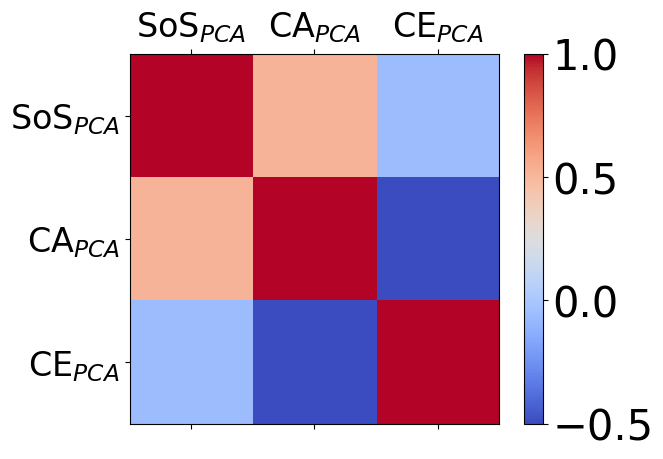

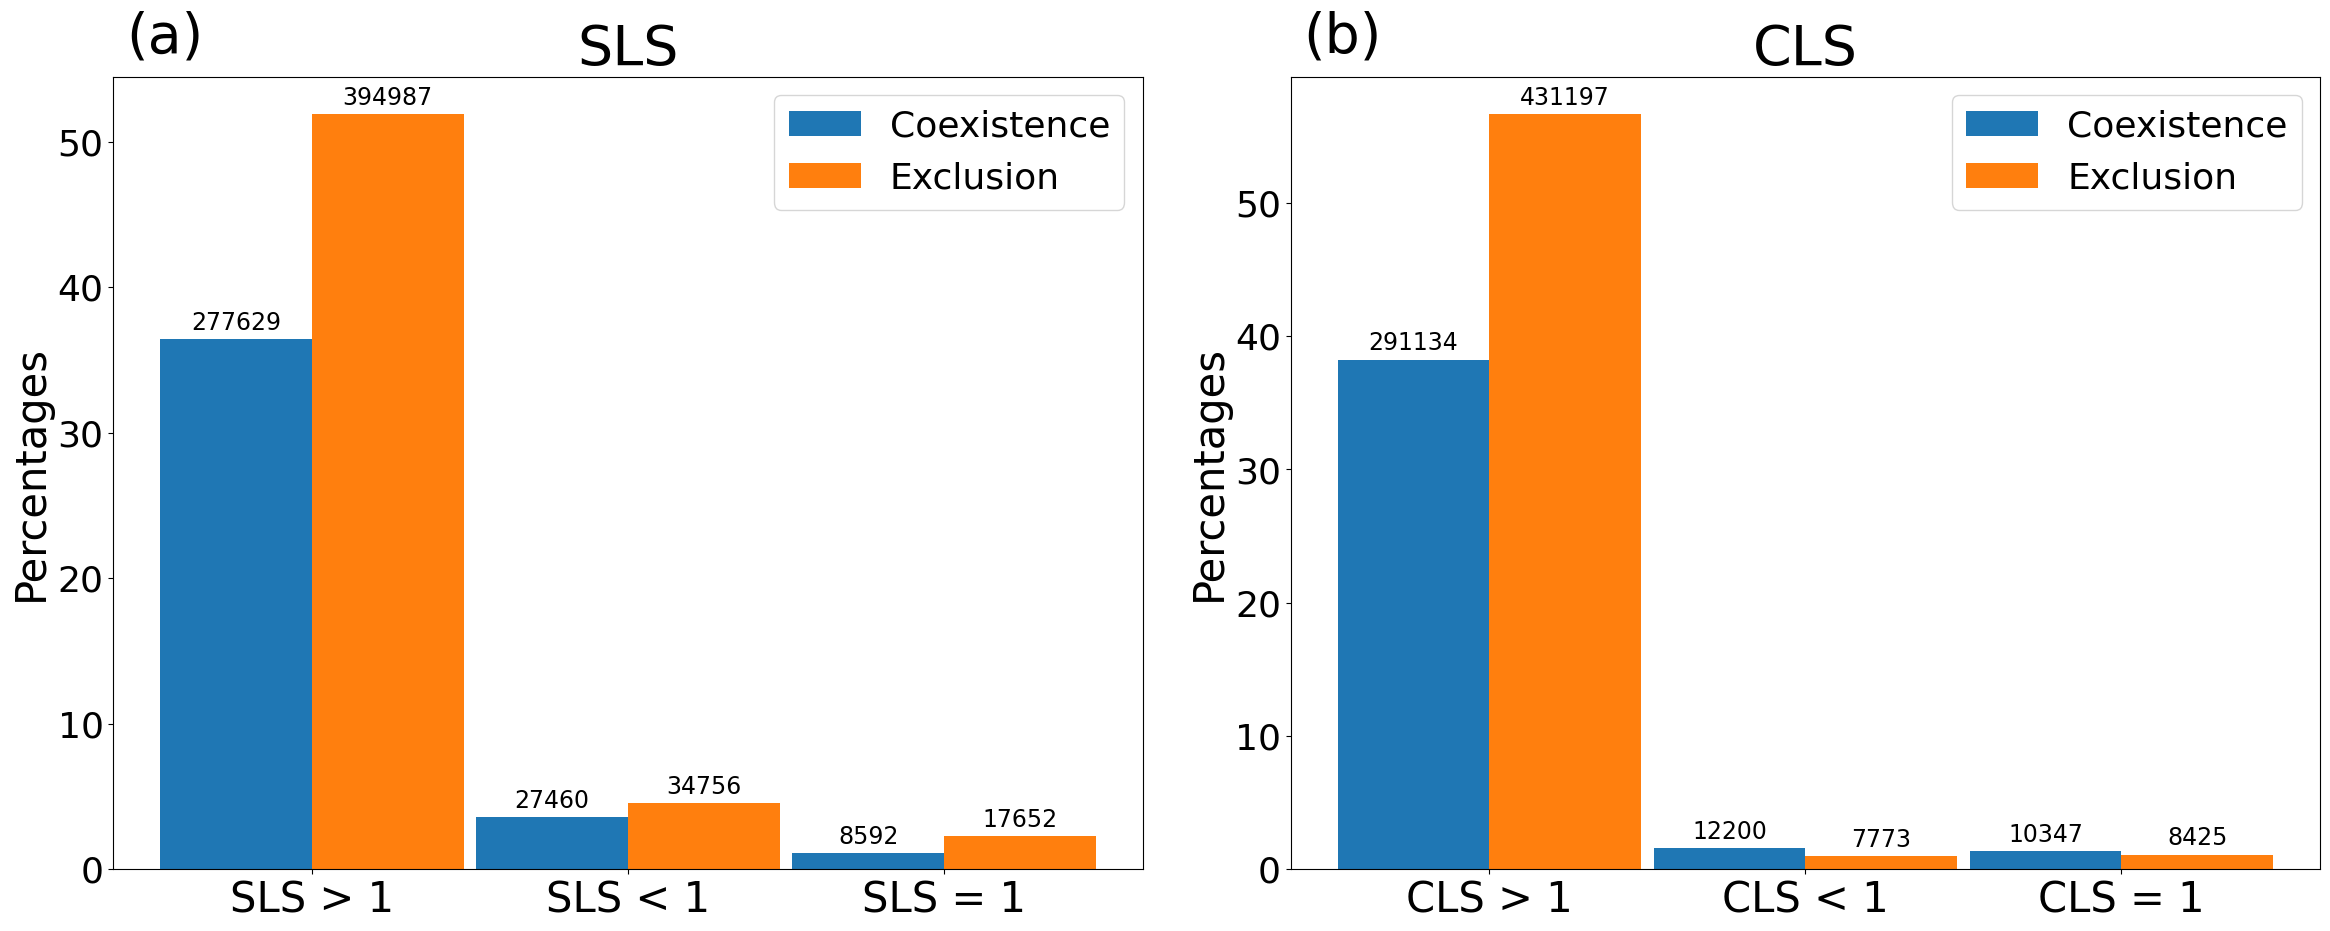

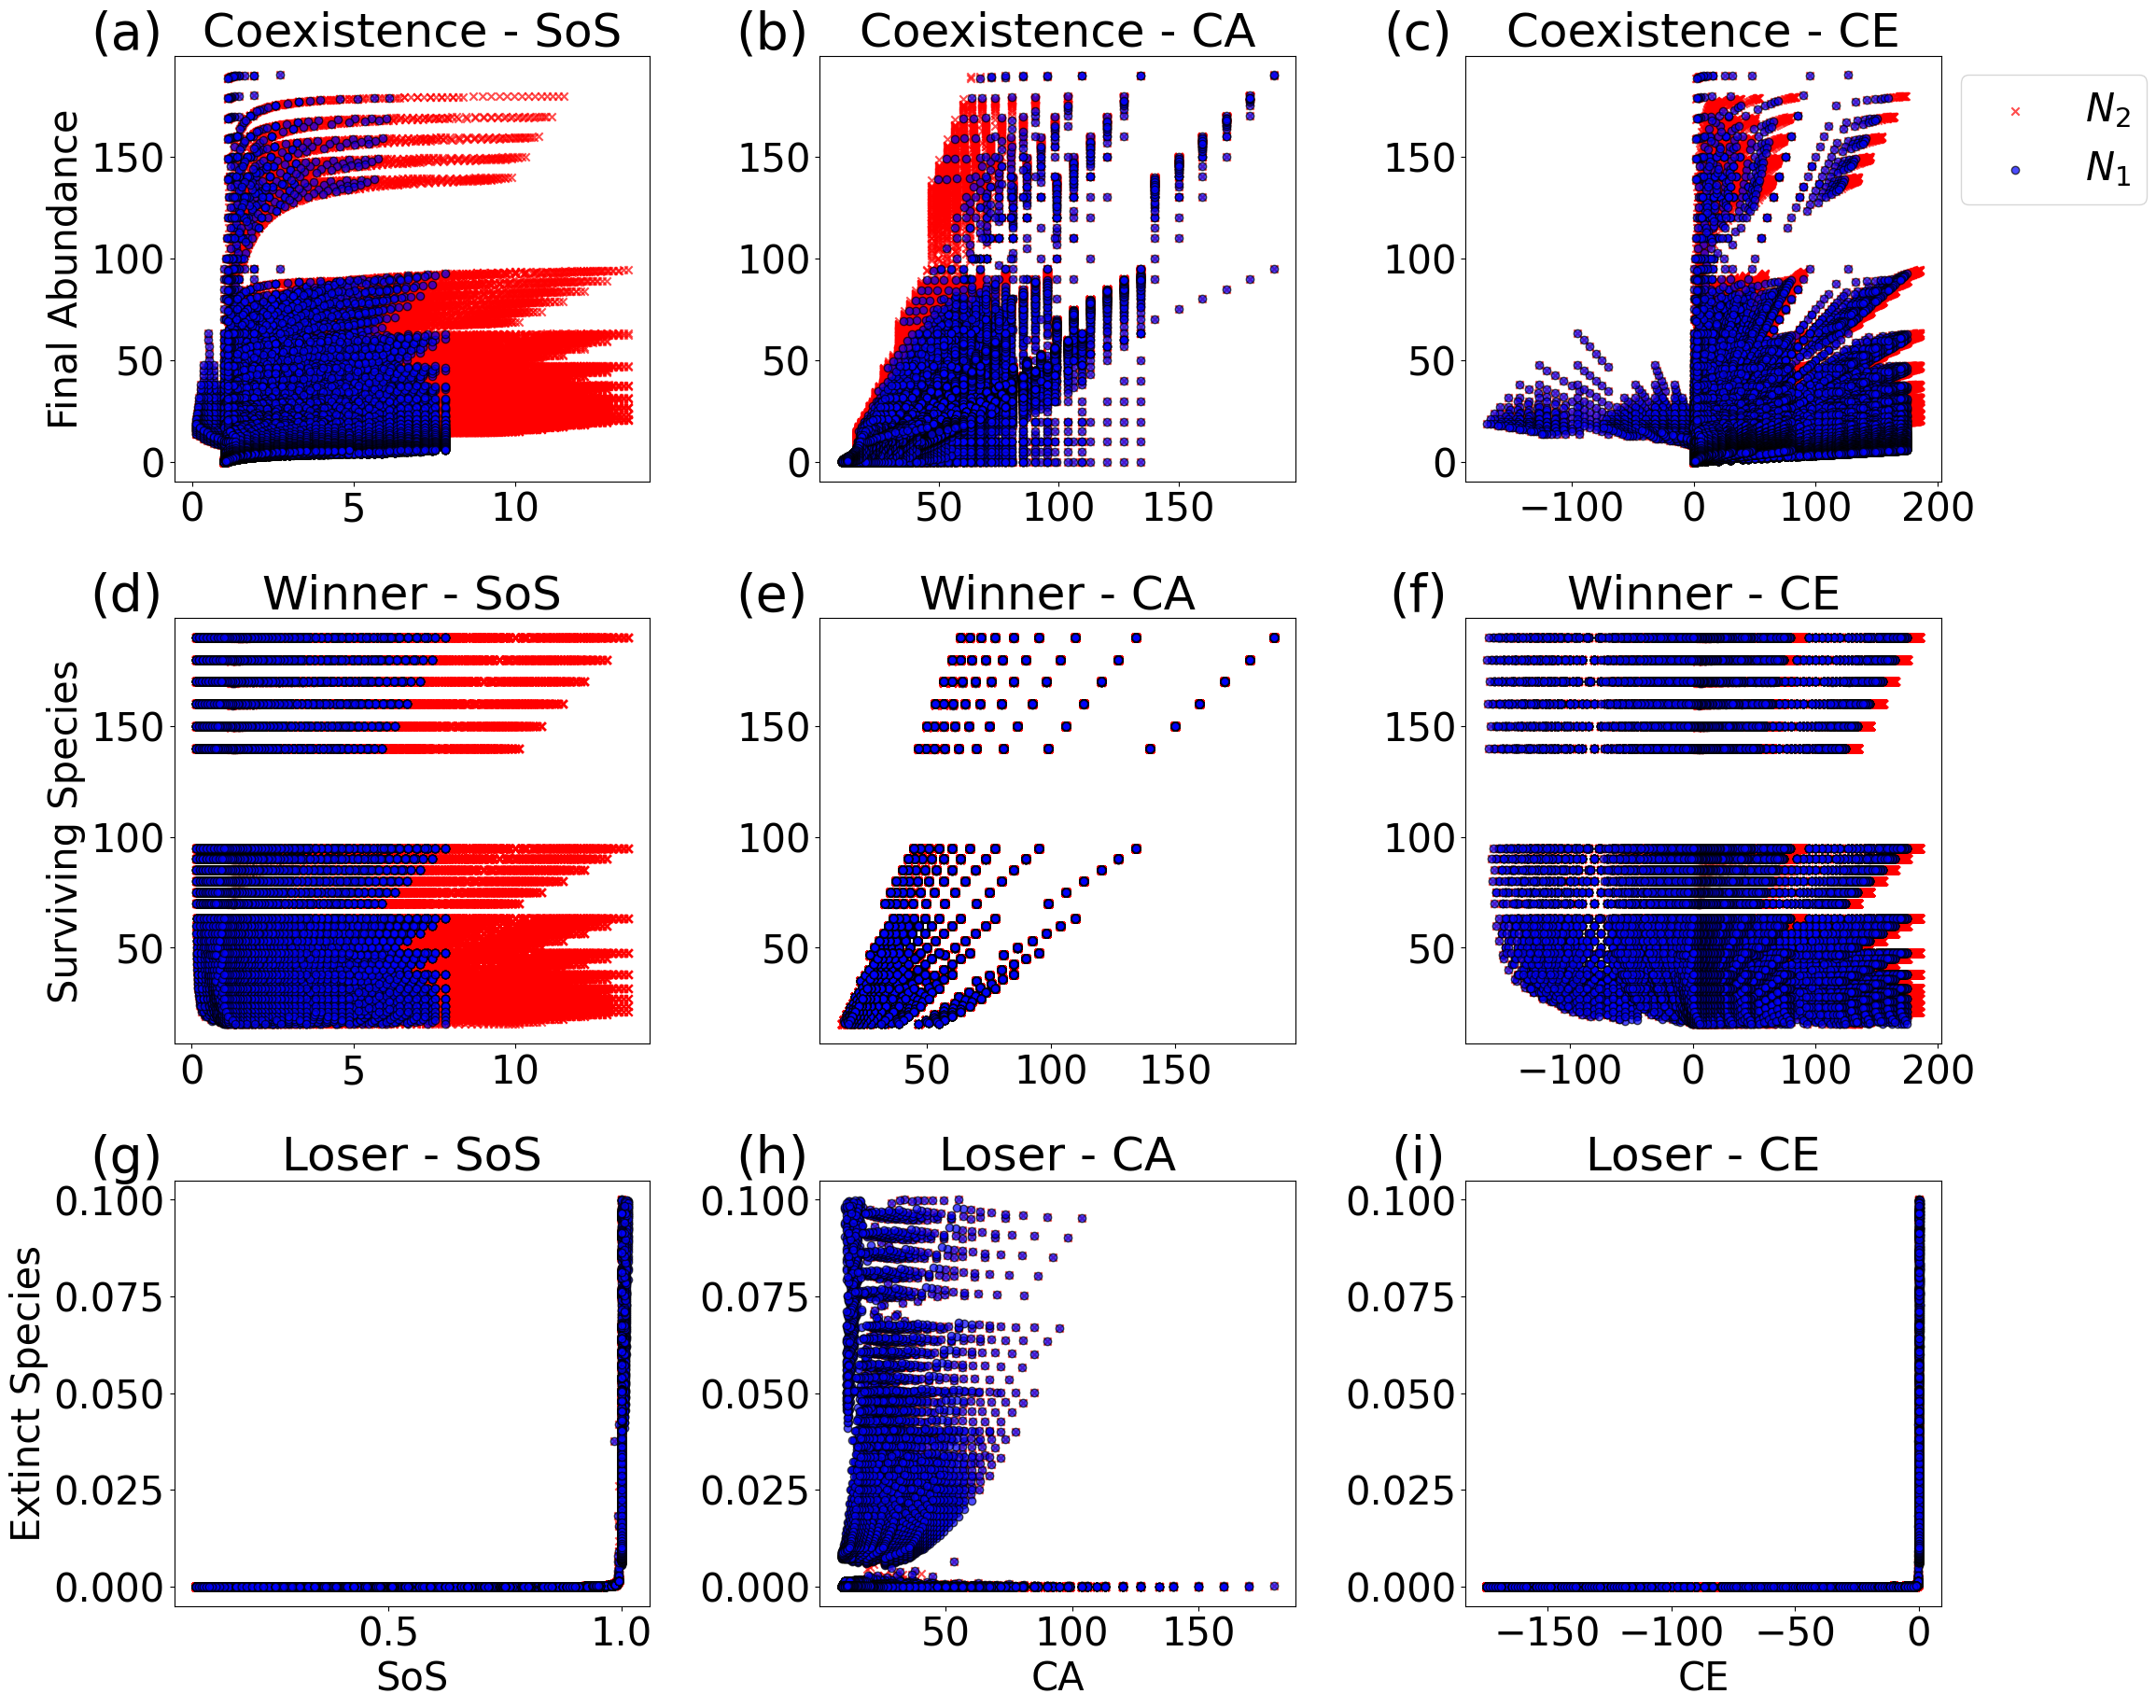

In [19]:
analyze_unfiltered()

# Analysis with N1 Rare Filter (Main Text)

Applying the filter took 11.58 seconds.
Starting Statistical analysis...

--------------------------------------------------------
Utilized Acronyms:
SoS: Strength of Stabilization
CA: Competitive Ability
CE: Competitive Efficiency
SLS: Self-Limitation Strength
CLS: Combined Limitation Strength
PCA: Principal Component Analysis
AIC: Akaike Information Criterion
AICc: Corrected Akaike Information Criterion
BIC: Bayesian Information Criterion
GLM: Generalized Linear Model
FE: Fitness Equivalence
N1, N2: Final abundance values for species 1 and 2
Intercept: Constant term in the GLM
--------------------------------------------------------

PCA applied for ['SoS1', 'SoS2'].
Explained Variance: 0.9069871524146149
PCA applied for ['FE1', 'FE2'].
Explained Variance: 0.9935095998041188

Model Summary for Strength of Stabilization with rarer_SLS:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                Outcome   No. Observations:               

PCA applied for ['CE1', 'CE2'].
Explained Variance: 0.5951672663861315

Model Summary for Competitive Efficiency with rarer_CLS:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                Outcome   No. Observations:               547591
Model:                            GLM   Df Residuals:                   547588
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3514e+05
Date:                Mon, 04 Dec 2023   Deviance:                   2.7029e+05
Time:                        18:02:32   Pearson chi2:                 5.19e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.5497
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-

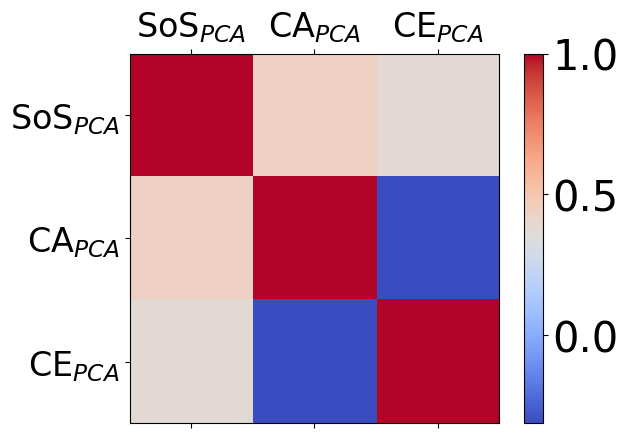

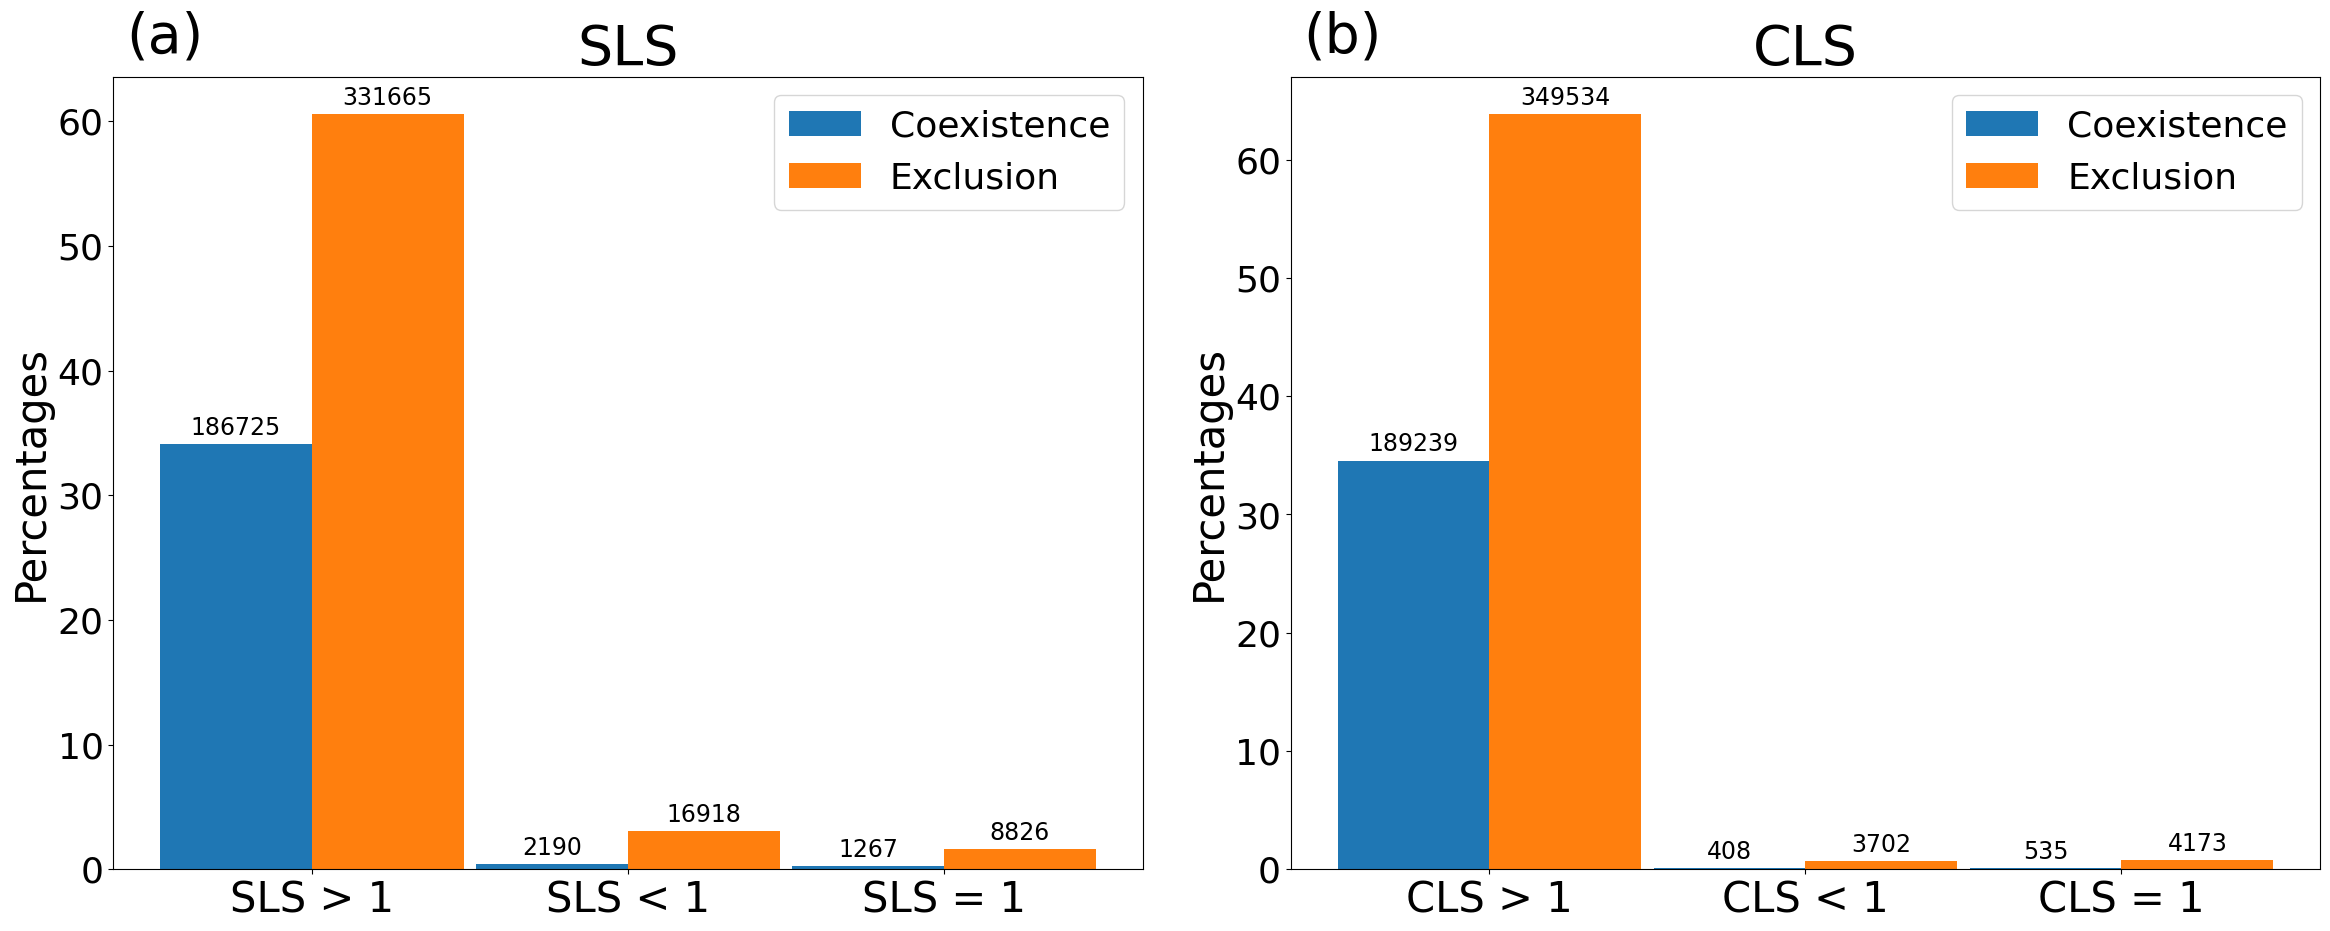

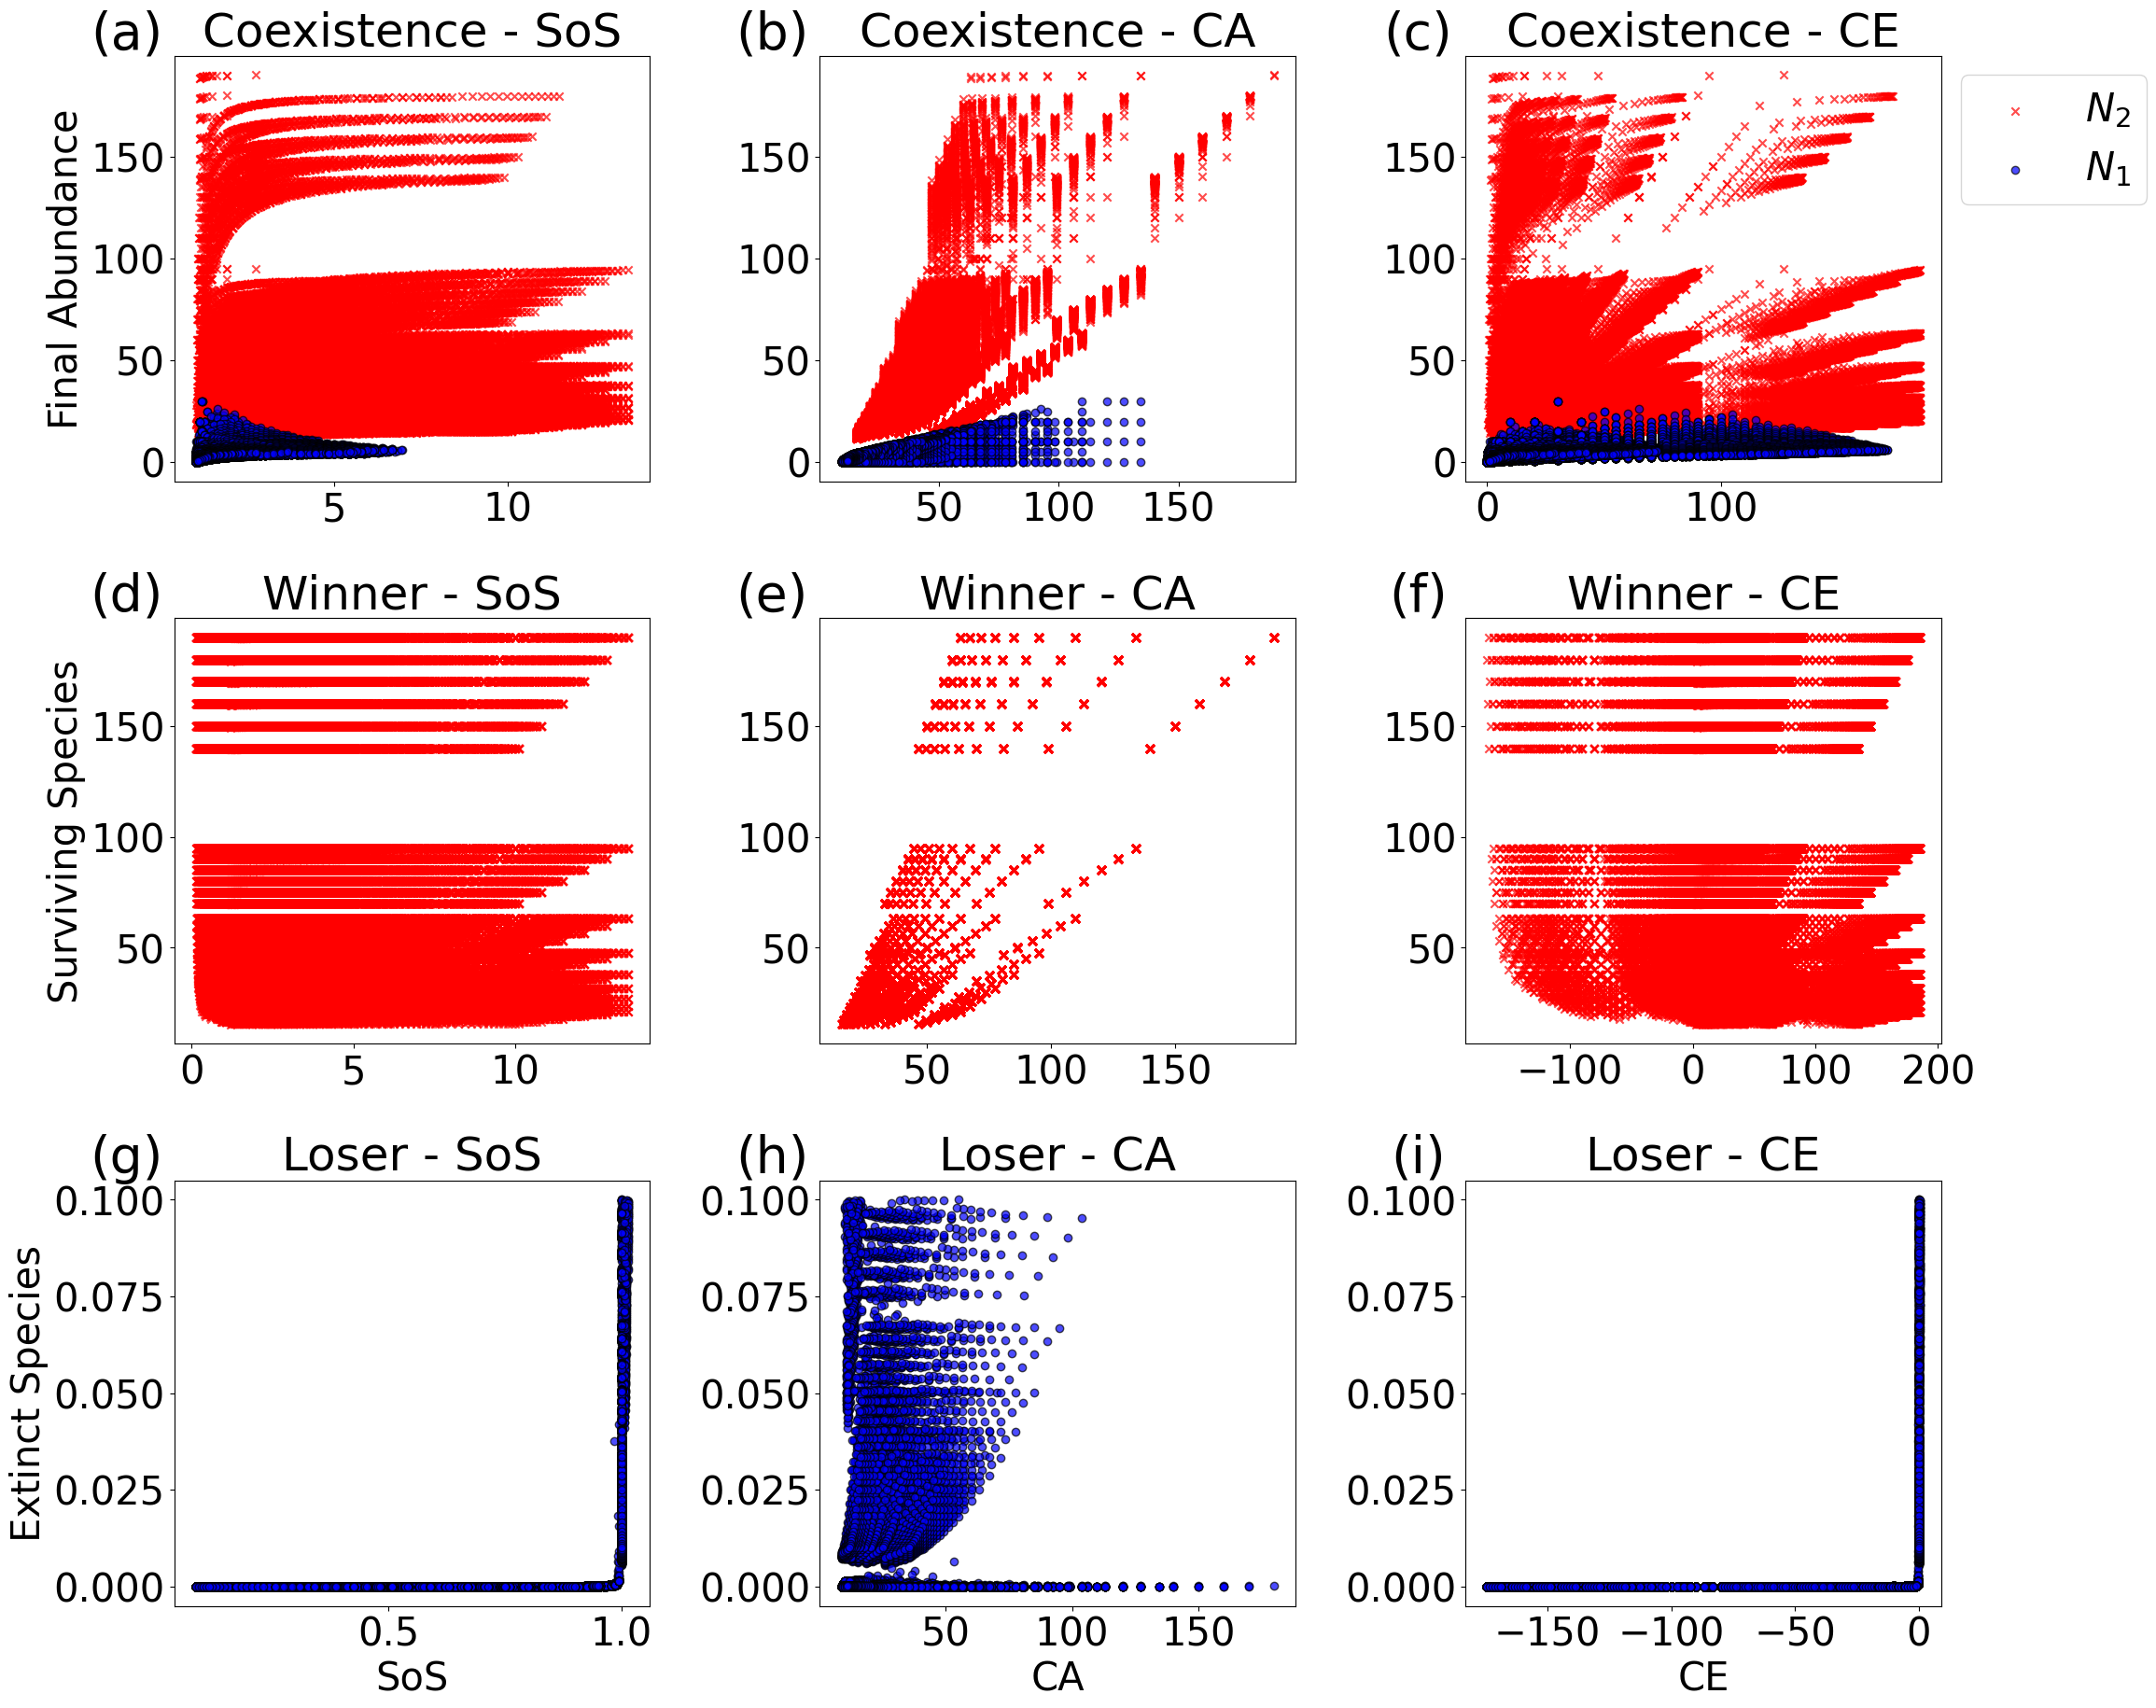

In [20]:
analyze_N1_rare()

# Analysis with N1 Rare and Strong Self-Limitation Filter (Appendix A)

Applying the filter took 1.25 seconds.
Starting Statistical analysis...

--------------------------------------------------------
Utilized Acronyms:
SoS: Strength of Stabilization
CA: Competitive Ability
CE: Competitive Efficiency
SLS: Self-Limitation Strength
CLS: Combined Limitation Strength
PCA: Principal Component Analysis
AIC: Akaike Information Criterion
AICc: Corrected Akaike Information Criterion
BIC: Bayesian Information Criterion
GLM: Generalized Linear Model
FE: Fitness Equivalence
N1, N2: Final abundance values for species 1 and 2
Intercept: Constant term in the GLM
--------------------------------------------------------

PCA applied for ['SoS1', 'SoS2'].
Explained Variance: 0.9752858979625603
PCA applied for ['FE1', 'FE2'].
Explained Variance: 0.9940248530661632

Model Summary for Strength of Stabilization with rarer_SLS:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                Outcome   No. Observations:                


Comparison of AIC, AICc, and BIC weights for each model:
                                      Model           AIC          AICc  \
0  Strength of Stabilization with rarer_SLS  10957.363018  10957.365112   
1  Strength of Stabilization with rarer_CLS   7190.419339   7190.421433   
2        Competitive Ability with rarer_SLS  12576.547972  12576.549228   
3        Competitive Ability with rarer_CLS  13394.853914  13394.855170   
4     Competitive Efficiency with rarer_SLS  11215.961782  11215.963038   
5     Competitive Efficiency with rarer_CLS  10542.861471  10542.862727   

            BIC  AIC_weights  AICc_weights  BIC_weights  
0  10988.794468     0.164816      0.164816     0.164747  
1   7221.850788     0.223274      0.223274     0.223267  
2  12600.121559     0.144654      0.144654     0.144661  
3  13418.427501     0.135423      0.135423     0.135418  
4  11239.535369     0.161417      0.161417     0.161448  
5  10566.435058     0.170415      0.170415     0.170459  
Statistica

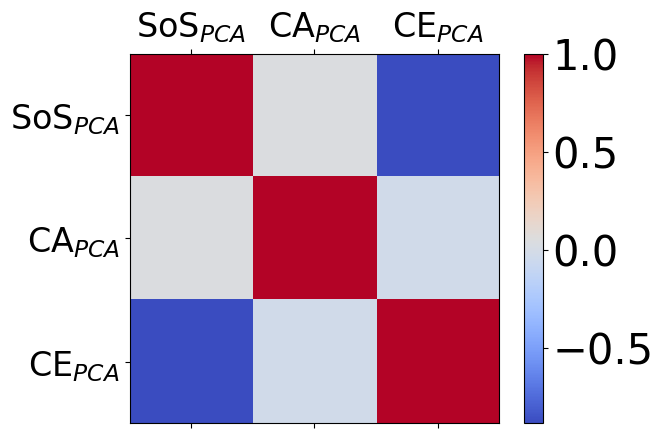

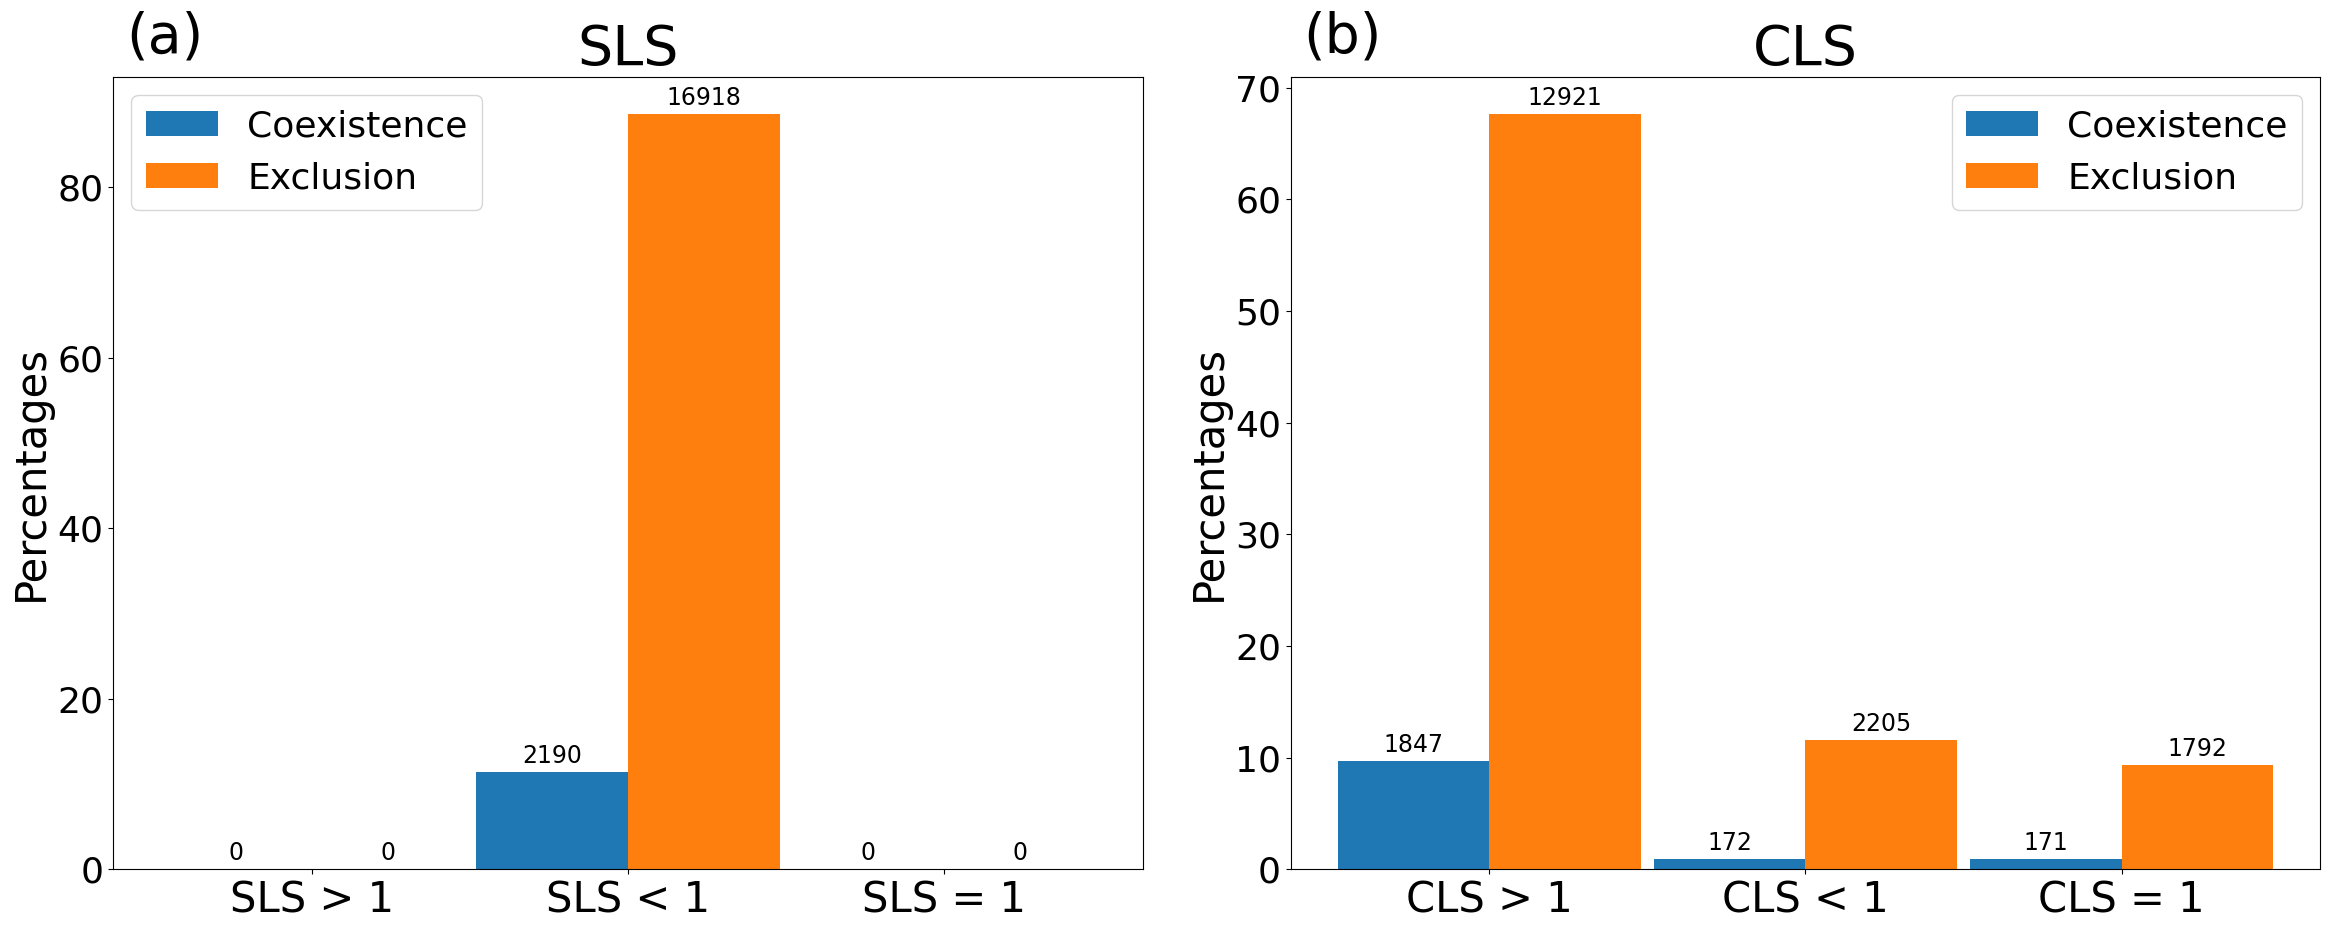

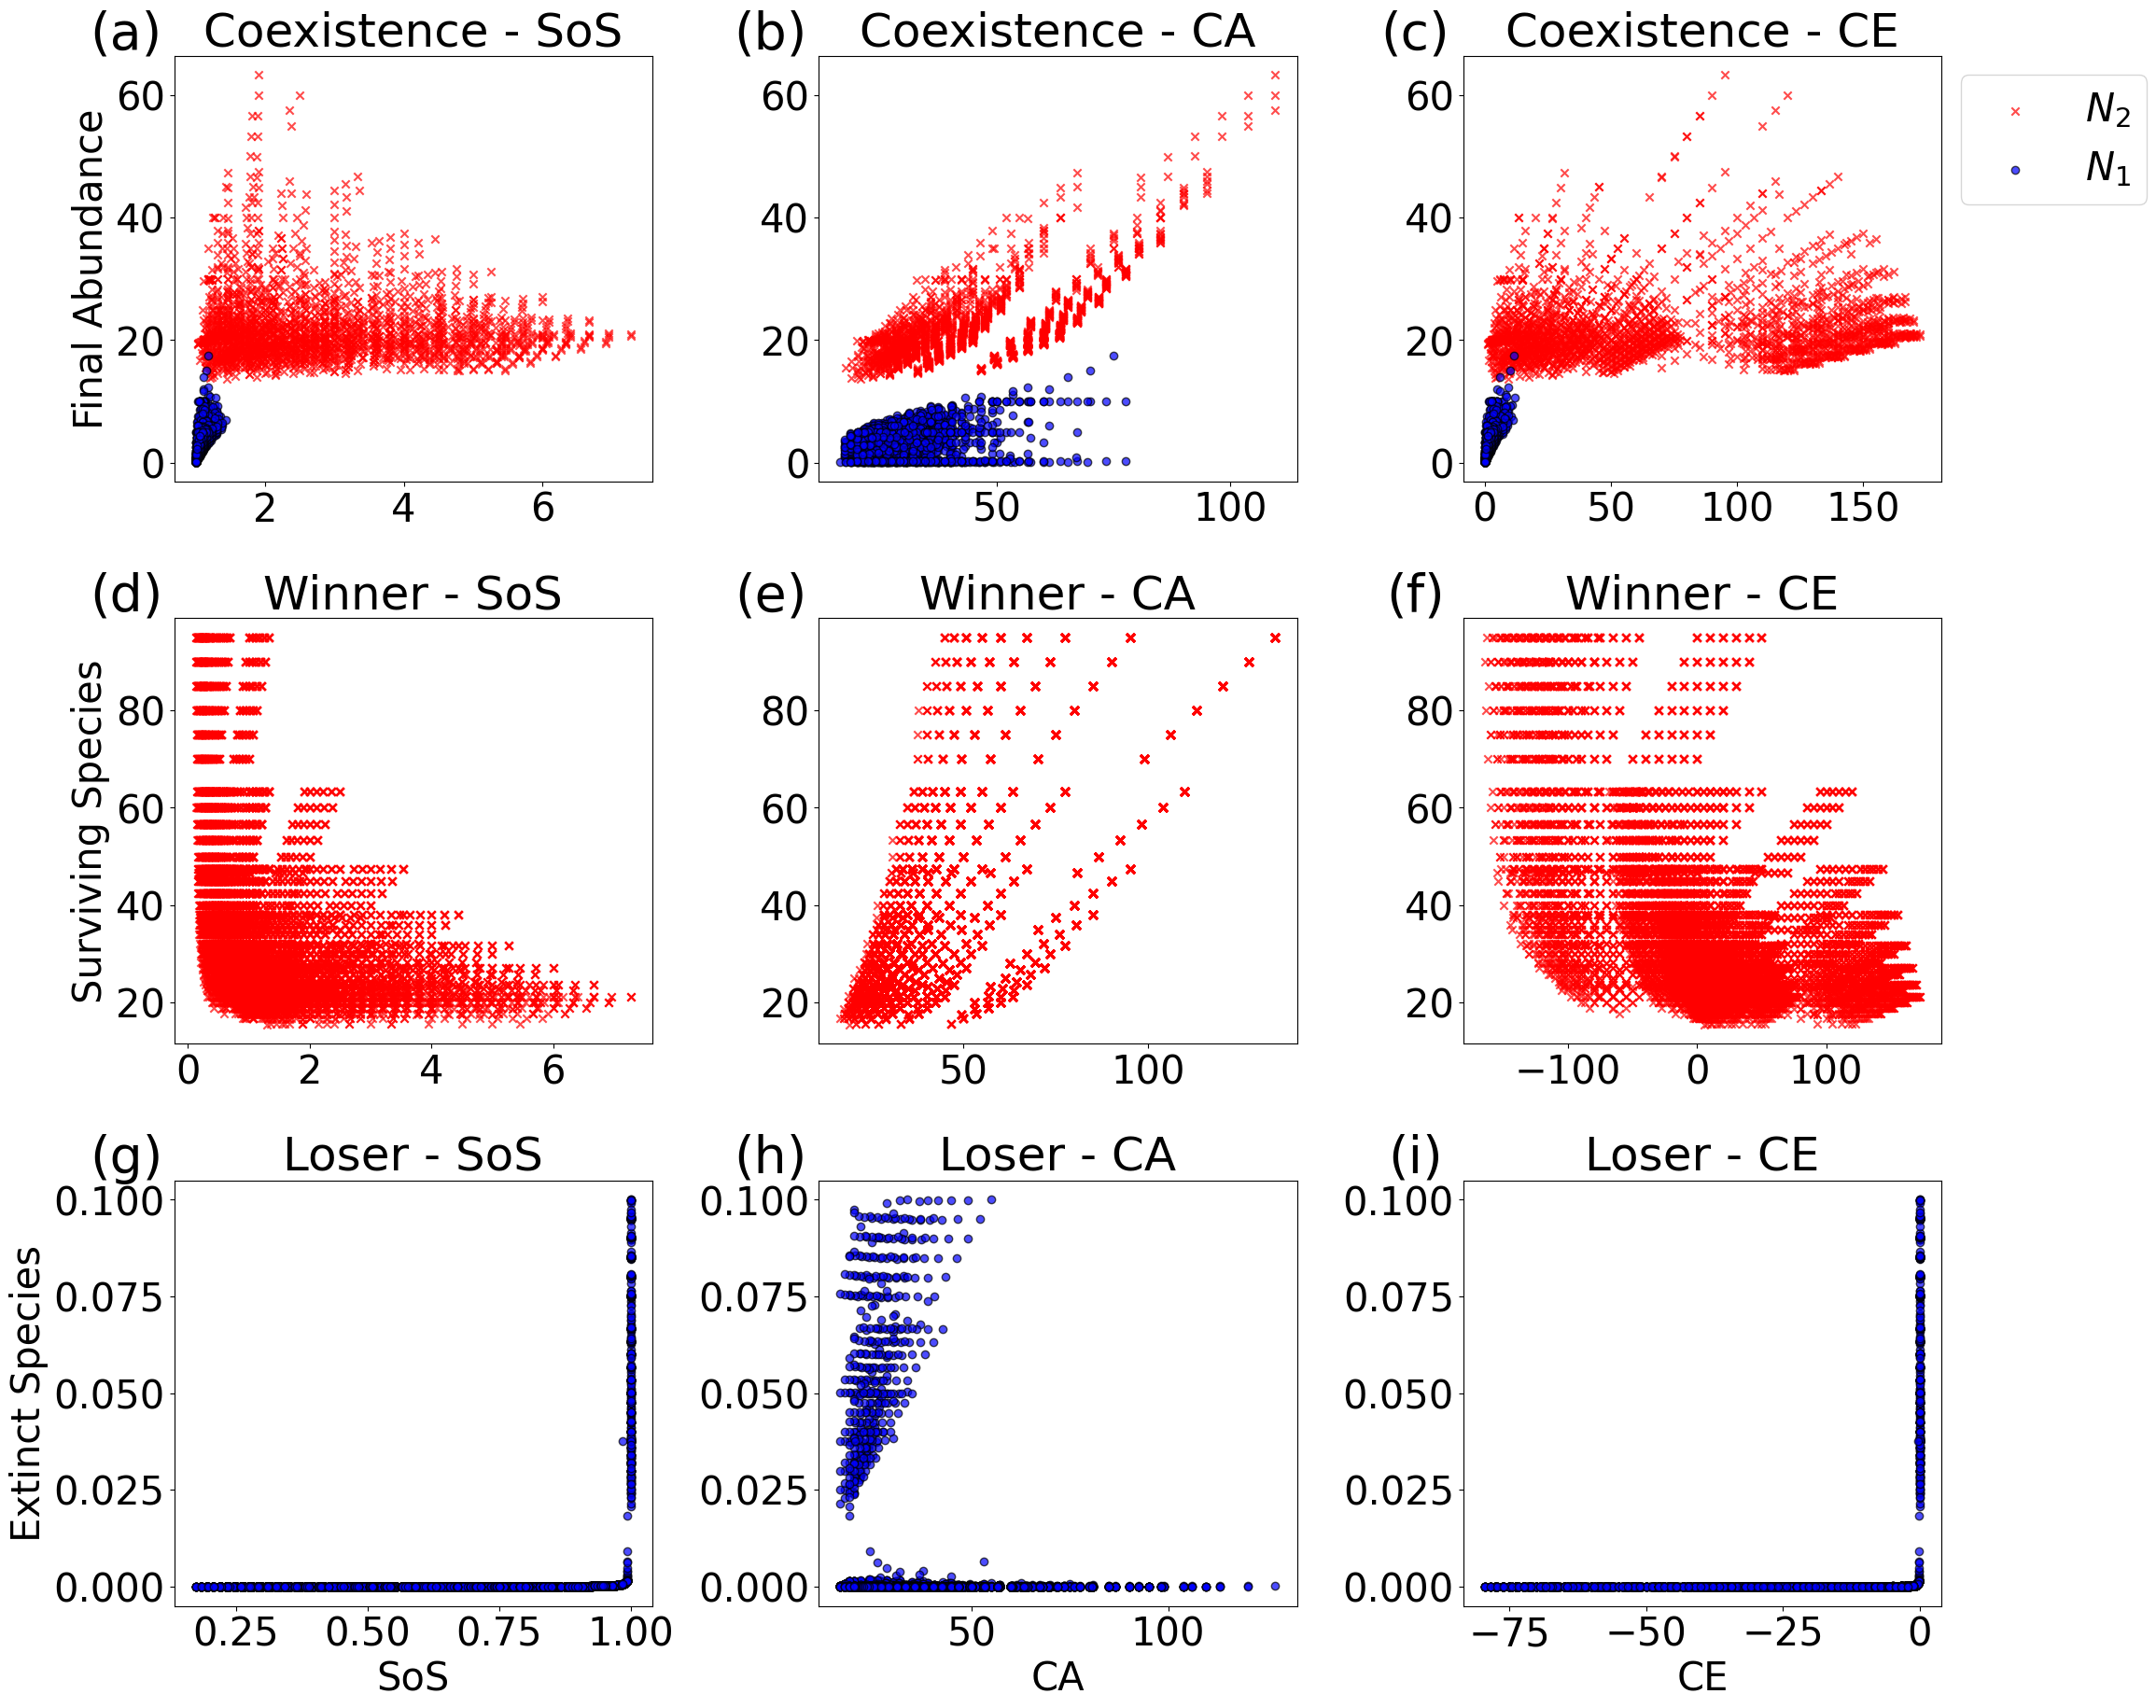

In [21]:
analyze_N1_rare_and_strong_self_limitation()

# Analysis with aii > aij (Appendix B)

Applying the filter took 0.04 seconds.
Starting Statistical analysis...

--------------------------------------------------------
Utilized Acronyms:
SoS: Strength of Stabilization
CA: Competitive Ability
CE: Competitive Efficiency
SLS: Self-Limitation Strength
CLS: Combined Limitation Strength
PCA: Principal Component Analysis
AIC: Akaike Information Criterion
AICc: Corrected Akaike Information Criterion
BIC: Bayesian Information Criterion
GLM: Generalized Linear Model
FE: Fitness Equivalence
N1, N2: Final abundance values for species 1 and 2
Intercept: Constant term in the GLM
--------------------------------------------------------

PCA applied for ['SoS1', 'SoS2'].
Explained Variance: 0.9973387120567409
PCA applied for ['FE1', 'FE2'].
Explained Variance: 0.9985280147975584

Model Summary for Strength of Stabilization with rarer_SLS:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                Outcome   No. Observations:                


Analysis Results for Extinct:
SoS:
count    23.000000
mean      0.977864
std       0.021376
min       0.950704
25%       0.950704
50%       0.983607
75%       1.000000
max       1.000000
dtype: float64
CA:
count    23.000000
mean     19.589125
std       1.361632
min      18.708287
25%      18.708287
50%      18.708287
75%      21.602469
max      21.602469
dtype: float64
CE:
count    2.300000e+01
mean    -5.132850e-01
std      4.782642e-01
min     -1.111111e+00
25%     -1.111111e+00
50%     -4.166667e-01
75%     -3.552714e-15
max     -3.552714e-15
dtype: float64

Analysis Results for Surviving_Competition:
SoS:
count    23.000000
mean      2.927574
std       1.845480
min       1.266667
25%       1.595318
50%       2.222222
75%       3.600000
max       7.272727
dtype: float64
CA:
count    23.000000
mean     35.175903
std      13.360840
min      21.213203
25%      25.622772
50%      30.041638
75%      40.604997
max      67.175144
dtype: float64
CE:
count     23.000000
mean      46.880435

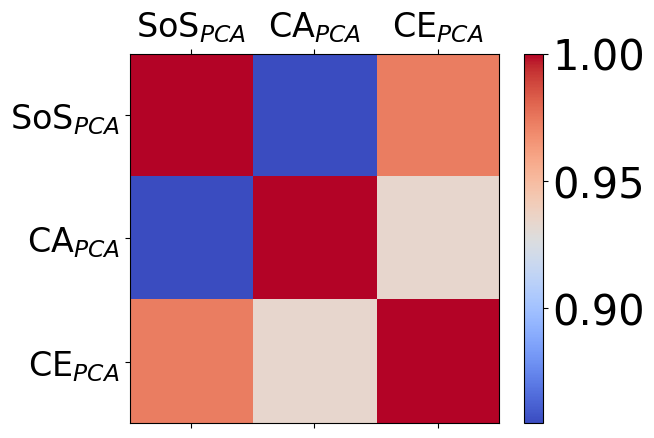

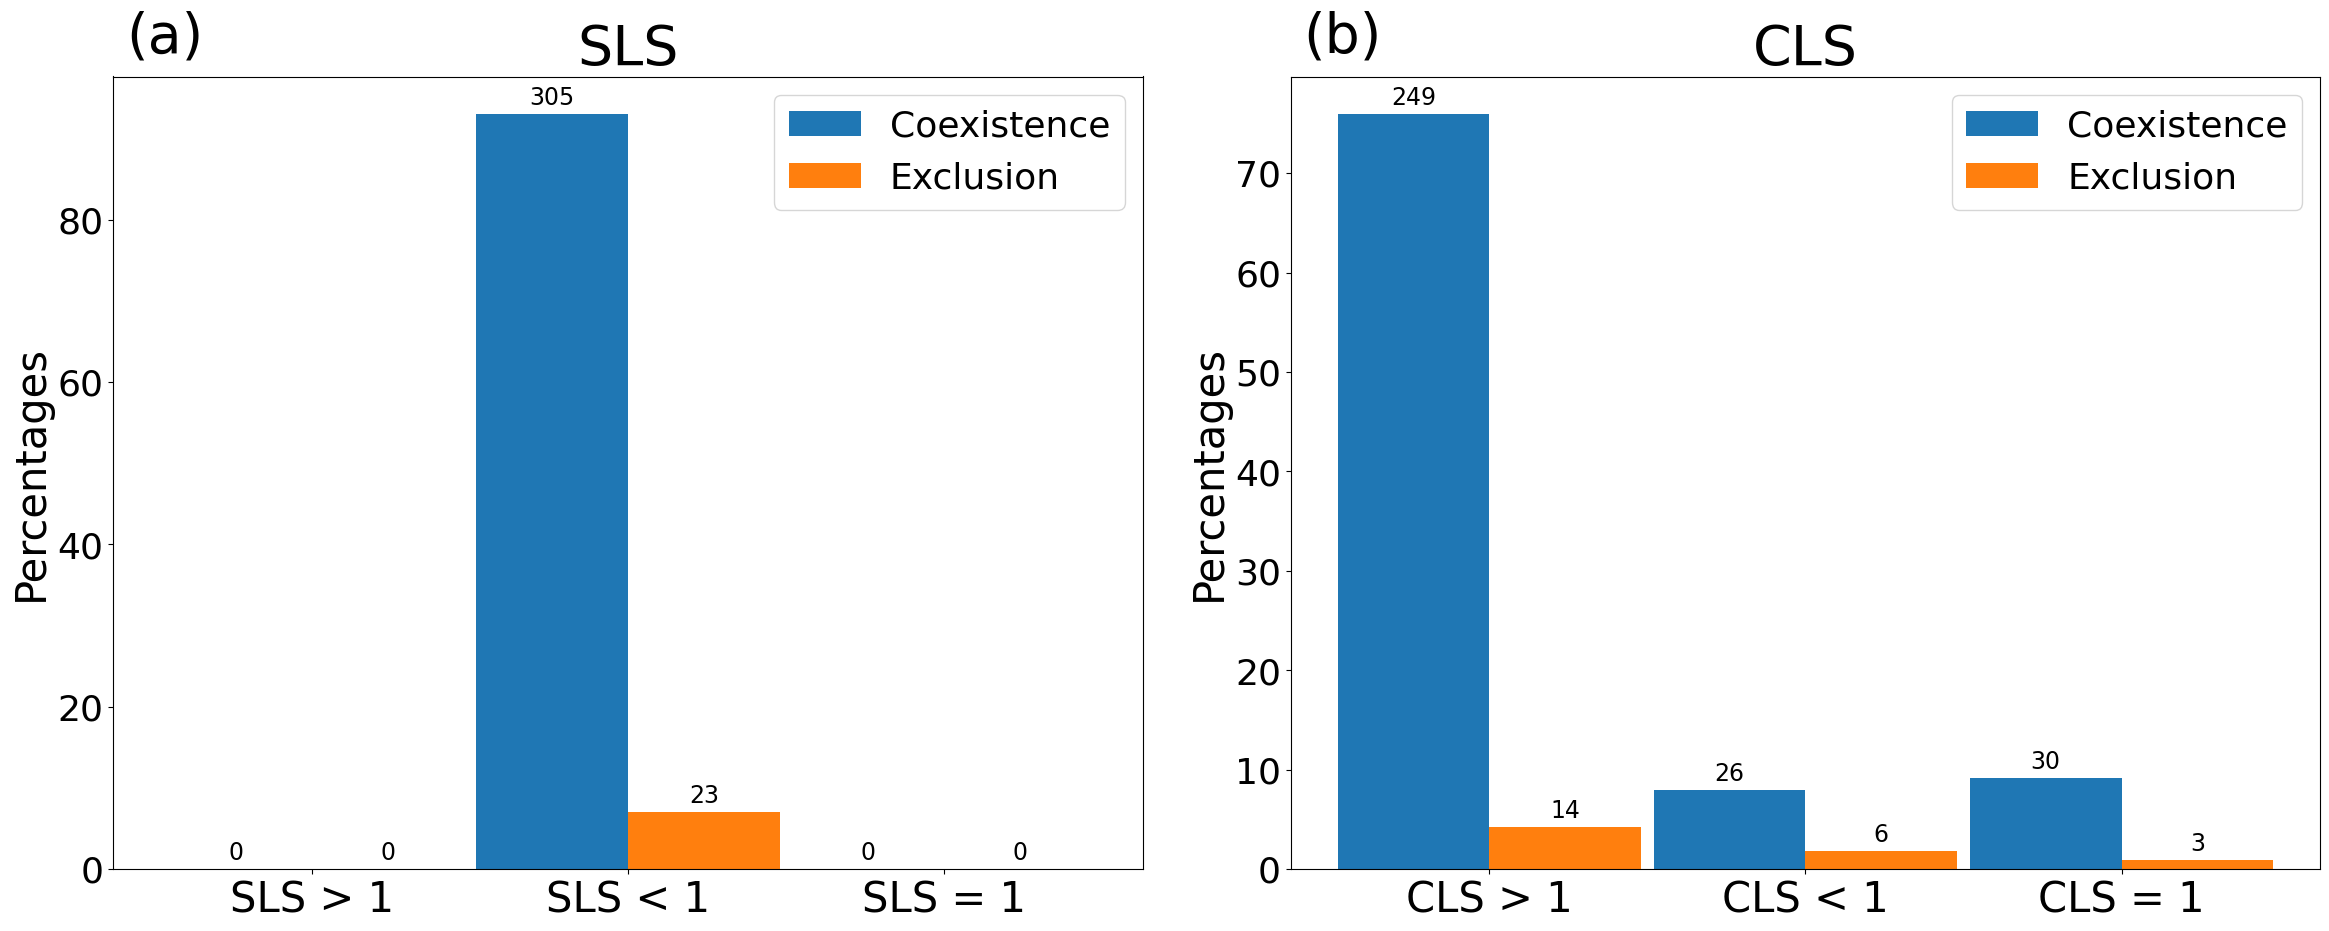

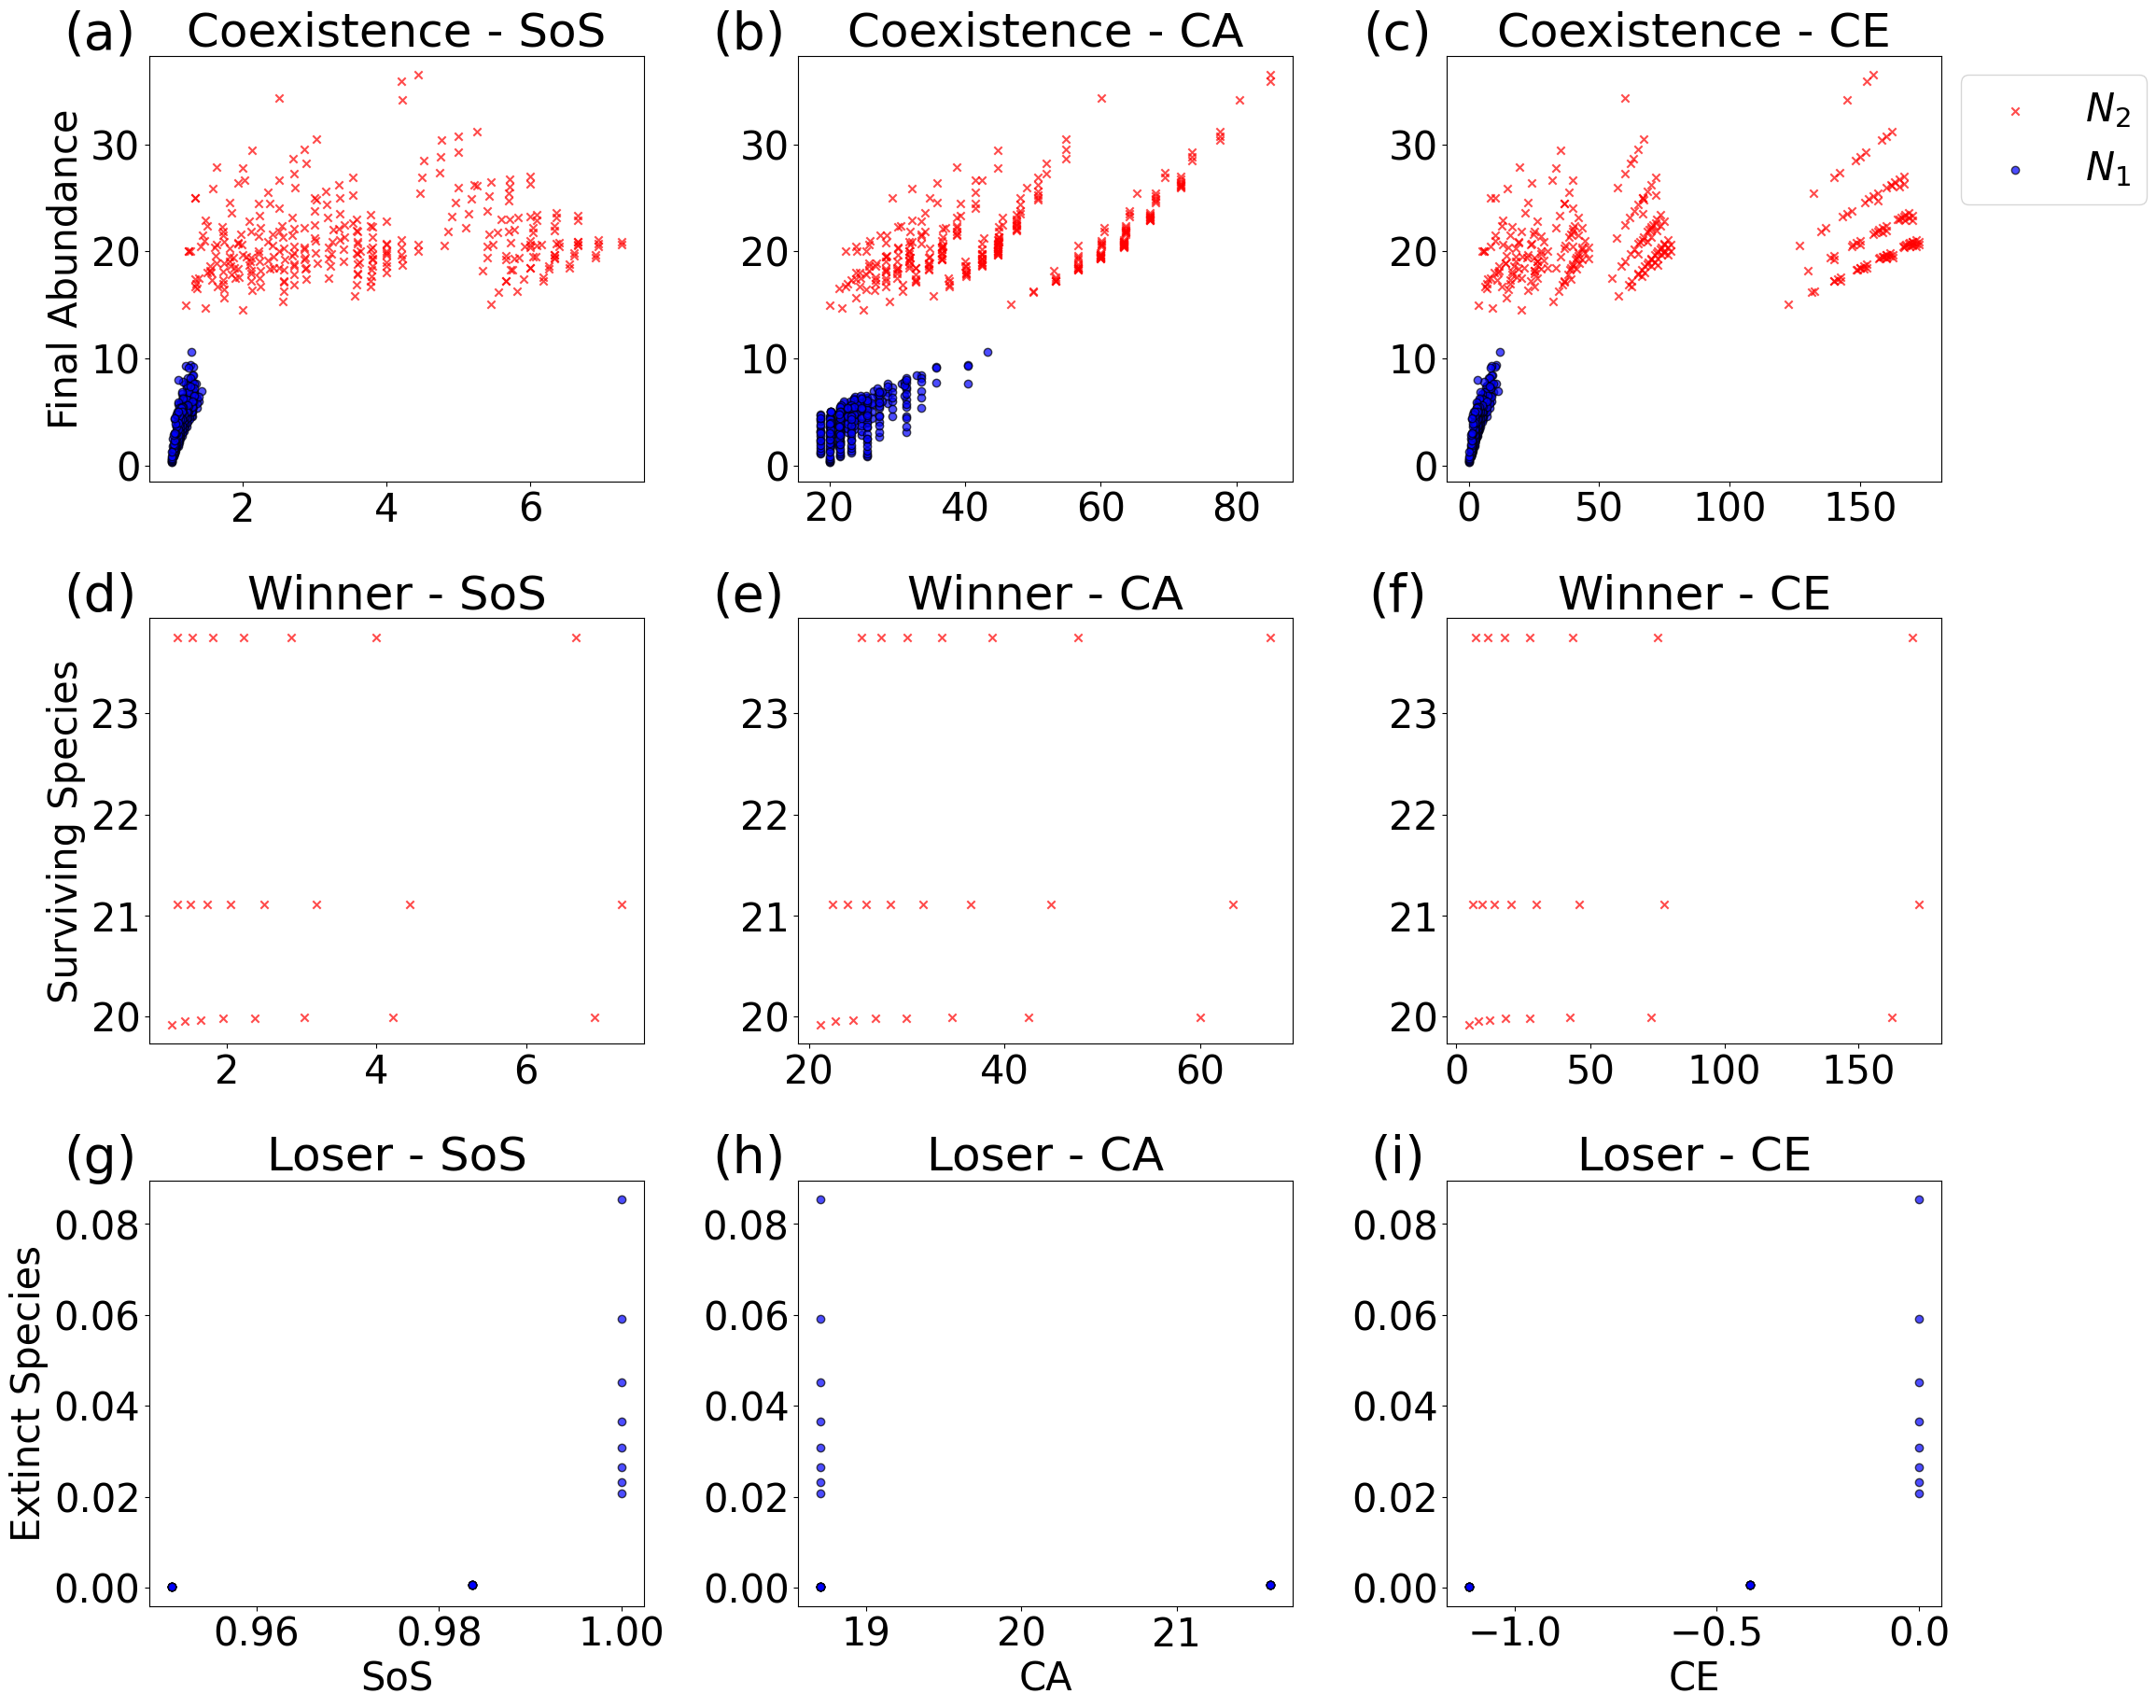

In [22]:
analyze_intraspecific_stronger()

# Remove the Big CSV File annplant_2spp_det_rare_unfiltered_copy.csv

def delete_file(filename):
    if os.path.exists(filename):
        os.remove(filename)
        print(f"Deleted file: {filename}")
    else:
        print(f"File not found: {filename}")

def complete_analysis_workflow():
    analyze_unfiltered()
    analyze_N1_rare()
    analyze_N1_rare_and_strong_self_limitation()
    analyze_intraspecific_stronger()

    # Delete the unfiltered copy after all analyses
    unfiltered_copy_filename = os.path.join("csv", "annplant_2spp_det_rare_unfiltered_copy.csv")
    delete_file(unfiltered_copy_filename)

if __name__ == "__main__":
    complete_analysis_workflow()